In [449]:
# Dependencies

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%matplotlib inline

In [450]:
# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split  # not used here, we use <2015 and >=2015 to split data
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# for integer encoding using sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# Set seed for reproducibility
seed1, seed2, seed3=101,67, 42

### load and merge data

In [451]:
# load the data from csv to pandas dataframe
provider = pd.read_csv("data/Train-1542865627584.csv")
beneficiary = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")
inpatient= pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")
outpatient = pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")

In [452]:
# Assign inpatient data as 1, outpatient data as 0

inpatient['In_Out']=1
outpatient['In_Out']=0

In [453]:
# union/concat the inpatient and outpatient data
concat_df=pd.concat([inpatient, outpatient],axis=0)
concat_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In_Out
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1


In [454]:
merge_bene_df=concat_df.merge(beneficiary, on='BeneID', how='left')
merge_bene_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,1,2,1,1,36000,3204,60,70
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,1,2,1,1,36000,3204,60,70
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,1,2,1,2,2,2,21260,2136,120,100


In [455]:
merge_provider_df=merge_bene_df.merge(Healthcare_Provider_raw[['Provider','PotentialFraud']], on = 'Provider', how ='left')
merge_provider_df.drop_duplicates(inplace=True)

# remove columns with all null values
merge_provider_df.dropna(axis=1, how='all',inplace=True)

# check the final merged dataframe
merge_provider_df

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,2,1,2,2,2,21260,2136,120,100,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,...,1,2,2,1,2,0,0,5470,1870,No


In [456]:
merge_provider_df.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'In_Out', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes',

**Make a copy of dataframe only containing the code columns, the in_out column and the potential fraud column**

In [457]:
treat_codes_list = ['Provider','DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'In_Out','PotentialFraud']
treat_codes_df = merge_provider_df[treat_codes_list]
treat_codes_df

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,In_Out,PotentialFraud
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,1,Yes
1,PRV55907,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,1,No
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,No
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,1,No
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV53699,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,No
558207,PRV53702,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,No
558208,PRV53676,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,No
558209,PRV53689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,No


**Split into train and test first then do the count**

In [458]:
train_provider = pd.read_csv('../project2/train_provider_list.csv')
test_provider = pd.read_csv('../project2/test_provider_list.csv')
train_provider_list = train_provider.Provider.to_list()
test_provider_list = test_provider.Provider.to_list()
display(len(train_provider_list))
display(len(test_provider_list))

4328

1082

In [459]:
train_treat_codes = treat_codes_df[treat_codes_df['Provider'].isin(train_provider_list)]
test_treat_codes = treat_codes_df[treat_codes_df['Provider'].isin(test_provider_list)]
display(train_treat_codes.shape)
display(test_treat_codes.shape)

(443024, 19)

(115187, 19)

In [314]:
getUniqueCountsInColumns(test_treat_codes)    

Provider :  1082
DiagnosisGroupCode :  706
ClmDiagnosisCode_1 :  8149
ClmDiagnosisCode_2 :  3481
ClmDiagnosisCode_3 :  3008
ClmDiagnosisCode_4 :  2674
ClmDiagnosisCode_5 :  2299
ClmDiagnosisCode_6 :  2017
ClmDiagnosisCode_7 :  1862
ClmDiagnosisCode_8 :  1675
ClmDiagnosisCode_9 :  1478
ClmDiagnosisCode_10 :  457
ClmProcedureCode_1 :  607
ClmProcedureCode_2 :  154
ClmProcedureCode_3 :  60
ClmProcedureCode_4 :  21
ClmProcedureCode_5 :  4
In_Out :  2
PotentialFraud :  2


In [460]:
def getUniqueCountsInColumns(df):
    for column in df.columns:
        print(column, ': ' , len(df[column].unique()))
getUniqueCountsInColumns(train_treat_codes)    

Provider :  4328
DiagnosisGroupCode :  737
ClmDiagnosisCode_1 :  10159
ClmDiagnosisCode_2 :  5003
ClmDiagnosisCode_3 :  4504
ClmDiagnosisCode_4 :  4071
ClmDiagnosisCode_5 :  3729
ClmDiagnosisCode_6 :  3387
ClmDiagnosisCode_7 :  3159
ClmDiagnosisCode_8 :  2865
ClmDiagnosisCode_9 :  2562
ClmDiagnosisCode_10 :  1036
ClmProcedureCode_1 :  1055
ClmProcedureCode_2 :  276
ClmProcedureCode_3 :  144
ClmProcedureCode_4 :  45
ClmProcedureCode_5 :  5
In_Out :  2
PotentialFraud :  2


**Add columns to count the code number in diagnosis codes and procedure codes in each claim in test and train**

In [461]:
procedure_code_columns = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5']

In [462]:
'''columns: list of columns ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2']'''
def countCodeNumbers(df, columns):
    df_codes = treat_codes_df.loc[:, columns]
    codecount = df_codes.notnull().sum(axis=1)
    return codecount

diagnosis_code_columns = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
           'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10' ]
procedure_code_columns = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5']

train_treat_codes['DiagnosisCodeCount'] = countCodeNumbers(train_treat_codes, diagnosis_code_columns)
train_treat_codes['ProcedureCodeCount'] = countCodeNumbers(train_treat_codes, procedure_code_columns)

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2776962703.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_treat_codes['DiagnosisCodeCount'] = countCodeNumbers(train_treat_codes, diagnosis_code_columns)
/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2776962703.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_treat_codes['ProcedureCodeCount'] = countCodeNumbers(train_treat_codes, procedure_code_columns)


In [463]:
train_treat_codes

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,In_Out,PotentialFraud,DiagnosisCodeCount,ProcedureCodeCount
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,...,NaN,NaN,NaN,NaN,NaN,NaN,1,Yes,9,0
1,PRV55907,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,...,NaN,7092.0,NaN,NaN,NaN,NaN,1,No,3,1
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,No,6,0
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,...,NaN,331.0,NaN,NaN,NaN,NaN,1,No,9,1
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,...,NaN,3893.0,NaN,NaN,NaN,NaN,1,No,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,1749,V5811,V146,V5869,2752,V861,V5866,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,Yes,7,0
558195,PRV51836,NaN,5160,V5869,E9289,71690,412,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,Yes,5,0
558207,PRV53702,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,No,3,0
558209,PRV53689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,No,0,0


In [464]:
test_treat_codes['DiagnosisCodeCount'] = countCodeNumbers(test_treat_codes, diagnosis_code_columns)
test_treat_codes['ProcedureCodeCount'] = countCodeNumbers(test_treat_codes, procedure_code_columns)
test_treat_codes

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/879582076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_treat_codes['DiagnosisCodeCount'] = countCodeNumbers(test_treat_codes, diagnosis_code_columns)
/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/879582076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_treat_codes['ProcedureCodeCount'] = countCodeNumbers(test_treat_codes, procedure_code_columns)


,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,In_Out,PotentialFraud,DiagnosisCodeCount,ProcedureCodeCount
9,PRV55215,262,41041,3669,V851,25062,V074,2766,4019,4111,...,NaN,3612.0,4139.0,NaN,NaN,NaN,1,Yes,9,2
12,PRV55846,030,43411,27651,2724,36236,4019,71589,42731,43310,...,NaN,9904.0,4019.0,NaN,NaN,NaN,1,No,8,2
18,PRV54675,627,25081,53550,4149,42832,4148,38611,4660,3572,...,NaN,3893.0,7904.0,NaN,NaN,NaN,1,Yes,9,2
24,PRV53937,688,5990,78829,53081,41401,5845,4280,591,V1301,...,NaN,9904.0,5849.0,NaN,NaN,NaN,1,Yes,9,2
25,PRV51710,175,49121,2724,E9320,2449,41401,V5866,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,No,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,PRV53670,NaN,29561,V5869,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,Yes,2,0
558204,PRV53676,NaN,30279,V5869,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,No,2,0
558205,PRV53699,NaN,29212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,No,1,0
558206,PRV53699,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,No,3,0


In [465]:
def mergeDictionaryWithUpdate(dict_1, dict_2):
    for key in dict_2:
        value = dict_2[key]
       # print(key, value)
        if key not in dict_1:
            dict_1[key] = value
        else:
            old_value = int(dict_1[key])
            dict_1[key] = old_value + value
    return dict_1        

In [466]:
'''Get total counts of codes'''
def getTotalCodeCounts(df, columns):
    code_counts = {}
    for column in columns:
    
        value_counts = df[column].value_counts().to_dict()
        code_counts = mergeDictionaryWithUpdate(code_counts, value_counts)
    sorted_counts = dict(sorted(code_counts.items(), key=lambda item: item[1], reverse=True))
   # top50 = pd.DataFrame(sorted_counts.items(), columns= ['Code', 'Count'])[0:50]
    return sorted_counts    

**In train data, find the code frequency**

In [467]:
train_diag_codes_counts = getTotalCodeCounts(train_treat_codes, diagnosis_code_columns)
#train_diag_codes_counts

In [468]:
train_proc_codes_counts = getTotalCodeCounts(train_treat_codes, procedure_code_columns)
#train_proc_codes_counts

In [469]:
def getFrequencyGroups(dictionary, high, medium_high, medium, low):
    high_frequency = []
    medium_high_frequency = []
    medium_frequency = []
    low_fequency = []
    rare_frequency = []
    for key in dictionary:
        value = dictionary[key]
        if value >= high:
            high_frequency.append(key)
        elif value < high and value >= medium_high:
            medium_high_frequency.append(key)
        elif value < medium_high and value >= medium:
            medium_frequency.append(key)
        elif value < medium and value >= low:
            low_fequency.append(key)
        else:
            rare_frequency.append(key)
    results = []
    results.extend((high_frequency, medium_high_frequency, medium_frequency, low_fequency, rare_frequency))
    return results

In [470]:
#Get frequency groups for diagnosis and procedure code in train data set
train_diag_code_frequency_group = getFrequencyGroups(train_diag_codes_counts, 10000, 5000, 800, 500)
train_proc_code_frequency_group = getFrequencyGroups(train_proc_codes_counts, 500, 100, 10, 5)

In [471]:
train_diag_code_high_freq = train_diag_code_frequency_group[0]
train_diag_code_medium_high_freq = train_diag_code_frequency_group[1]
train_diag_code_medium_freq = train_diag_code_frequency_group[2]
train_diag_code_low_freq = train_diag_code_frequency_group[3]
train_diag_code_rare_freq = train_diag_code_frequency_group[4]

In [472]:
display(len(train_diag_code_high_freq))
display(len(train_diag_code_medium_high_freq))
display(len(train_diag_code_medium_freq))
display(len(train_diag_code_low_freq))
display(len(train_diag_code_rare_freq))

14

11

237

146

10336

In [473]:
train_proc_code_high_freq = train_proc_code_frequency_group[0]
train_proc_code_medium_high_freq = train_proc_code_frequency_group[1]
train_proc_code_medium_freq = train_proc_code_frequency_group[2]
train_proc_code_low_freq = train_proc_code_frequency_group[3]
train_proc_code_rare_freq = train_proc_code_frequency_group[4]

In [474]:
display(len(train_proc_code_high_freq))
display(len(train_proc_code_medium_high_freq))
display(len(train_proc_code_medium_freq))
display(len(train_proc_code_low_freq))
display(len(train_proc_code_rare_freq))

8

37

280

162

765

In [475]:
def codeForfrequencyGroupCounts(df, columns, frequency_group):
    df_codes = df.loc[:, columns]
    codecount = df_codes.isin(frequency_group).sum(axis=1)
    return codecount
    
    

In [476]:
#get frequency group counts for diagnosis codes in train data
train_treat_codes['ClmDiagHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, diagnosis_code_columns, train_diag_code_high_freq)
train_treat_codes['ClmDiagMediumHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, diagnosis_code_columns, train_diag_code_medium_high_freq)
train_treat_codes['ClmDiagMediumFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, diagnosis_code_columns, train_diag_code_medium_freq)
train_treat_codes['ClmDiagLowFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, diagnosis_code_columns, train_diag_code_low_freq)
train_treat_codes['ClmDiagRareFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, diagnosis_code_columns, train_diag_code_rare_freq)

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/3350356293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_treat_codes['ClmDiagHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, diagnosis_code_columns, train_diag_code_high_freq)
/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/3350356293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_treat_codes['ClmDiagMediumHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, diagnosis_code_colu

In [477]:
#get frequency group counts for procedure codes in train data
train_treat_codes['ClmProcHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, procedure_code_columns, train_proc_code_high_freq)
train_treat_codes['ClmProcMediumHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, procedure_code_columns, train_proc_code_medium_high_freq)
train_treat_codes['ClmProcMediumFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, procedure_code_columns, train_proc_code_medium_freq)
train_treat_codes['ClmProcLowFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, procedure_code_columns, train_proc_code_low_freq)
train_treat_codes['ClmProcRareFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, procedure_code_columns, train_proc_code_rare_freq)

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/1529216302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_treat_codes['ClmProcHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, procedure_code_columns, train_proc_code_high_freq)
/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/1529216302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_treat_codes['ClmProcMediumHighFreqCount'] = codeForfrequencyGroupCounts(train_treat_codes, procedure_code_colu

In [478]:
train_agg_1 = train_treat_codes.groupby('Provider').agg(MaxDiagCodeNumPerClaim = ('DiagnosisCodeCount', 'max'),
                                                      MeanDiagCodeNumPerClaim = ('DiagnosisCodeCount', 'mean'),
                                                      MaxProcCodeNumPerClaim = ('ProcedureCodeCount', 'max'),
                                                      MeanProcCodeNumPerClaim = ('ProcedureCodeCount', 'mean'),
                                                      TotalDiagCodeNum = ('DiagnosisCodeCount', 'sum'),
                                                      TotalProcCodeNum = ('ProcedureCodeCount', 'sum'),
                                                      
                                                      MeanHighFreqDiagCodeNumPerClaim = ('ClmDiagHighFreqCount', 'mean'),
                                                      
                                                      MeanMediumHighFreqDiagCodeNumPerClaim = ('ClmDiagMediumHighFreqCount', 'mean'),
    
                                                      MeanMediumFreqDiagCodeNumPerClaim = ('ClmDiagMediumFreqCount', 'mean'),
                                                
                                                      MeanLowFreqDiagCodeNumPerClaim = ('ClmDiagLowFreqCount', 'mean'),
                                                      
                                                      MeanRareFreqDiagCodeNumPerClaim = ('ClmDiagRareFreqCount', 'mean'),
                                                       
                                                      TotalHighFreqProcCodeNumPerClaim = ('ClmProcHighFreqCount', 'sum'),
                                                      
                                                      TotalMediumHighFreqProcCodeNumPerClaim = ('ClmProcMediumHighFreqCount', 'sum'),
                                                     
                                                      TotalMediumFreqProcCodeNumPerClaim = ('ClmProcMediumFreqCount', 'sum'),
                                                      
                                                      TotalLowFreqProcCodeNumPerClaim = ('ClmProcLowFreqCount', 'sum'),
                                                      
                                                      TotalRareFreqProcCodeNumPerClaim = ('ClmProcRareFreqCount', 'sum'))
train_agg_1

,MaxDiagCodeNumPerClaim,MeanDiagCodeNumPerClaim,MaxProcCodeNumPerClaim,MeanProcCodeNumPerClaim,TotalDiagCodeNum,TotalProcCodeNum,MeanHighFreqDiagCodeNumPerClaim,MeanMediumHighFreqDiagCodeNumPerClaim,MeanMediumFreqDiagCodeNumPerClaim,MeanLowFreqDiagCodeNumPerClaim,MeanRareFreqDiagCodeNumPerClaim,TotalHighFreqProcCodeNumPerClaim,TotalMediumHighFreqProcCodeNumPerClaim,TotalMediumFreqProcCodeNumPerClaim,TotalLowFreqProcCodeNumPerClaim,TotalRareFreqProcCodeNumPerClaim
Provider,,,,,,,,,,,,,,,,
PRV51001,9,3.200000,2,0.120000,80,3,0.560000,0.040000,1.040000,0.200000,1.360000,1,0,2,0,0
PRV51004,9,2.583893,0,0.000000,385,0,0.583893,0.127517,0.785235,0.140940,0.946309,0,0,0,0,0
PRV51005,10,2.588841,0,0.000000,3016,0,0.529614,0.137339,0.777682,0.156223,0.987983,0,0,0,0,0
PRV51008,10,3.162791,1,0.046512,136,2,0.813953,0.232558,0.953488,0.162791,1.000000,0,0,2,0,0
PRV51011,9,2.534483,0,0.000000,147,0,0.551724,0.120690,0.724138,0.172414,0.965517,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57758,5,3.500000,0,0.000000,7,0,1.000000,0.000000,1.500000,0.000000,1.000000,0,0,0,0,0
PRV57759,5,2.071429,0,0.000000,58,0,0.535714,0.142857,0.607143,0.071429,0.714286,0,0,0,0,0
PRV57760,7,2.363636,0,0.000000,52,0,0.500000,0.181818,0.590909,0.090909,1.000000,0,0,0,0,0


### one hot encoding

**Find top 15 codes and make other code 'Other'**

In [479]:
train_top_15_proc_codes = ['4019.0', '9904.0', '2724.0', '8154.0', '66.0', '3893.0', '3995.0', '4516.0',
 '3722.0', '8151.0', '8872.0', '9671.0','4513.0','5849.0', '9390.0', 'Other']

In [480]:
train_top_15_diag_codes = ['4019', '25000', '2724', 'V5869', '4011', '42731', 'V5861', '2720', '2449',
 '4280', '53081', '41401', '496', '2859', '41400', 'Other']

In [481]:
train_treat_codes_one_hot = train_treat_codes.copy(deep=True)


In [482]:
for column in diagnosis_code_columns:
    train_treat_codes_one_hot[column] =  train_treat_codes_one_hot[column].apply(lambda x : 'Other' if x not in top_15_diag_codes else x )
train_treat_codes_one_hot    

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagHighFreqCount,ClmDiagMediumHighFreqCount,ClmDiagMediumFreqCount,ClmDiagLowFreqCount,ClmDiagRareFreqCount,ClmProcHighFreqCount,ClmProcMediumHighFreqCount,ClmProcMediumFreqCount,ClmProcLowFreqCount,ClmProcRareFreqCount
0,PRV55912,201,Other,4019,Other,Other,Other,Other,2724,Other,...,2,1,3,1,2,0,0,0,0,0
1,PRV55907,750,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,2,0,1,0,0,1,0,0
2,PRV56046,883,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,3,1,2,0,0,0,0,0
3,PRV52405,067,Other,Other,Other,Other,Other,Other,Other,Other,...,1,0,5,0,3,0,0,1,0,0
4,PRV56614,975,Other,Other,Other,Other,Other,Other,Other,Other,...,0,1,4,1,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,Other,Other,Other,V5869,Other,Other,Other,Other,...,1,0,4,0,2,0,0,0,0,0
558195,PRV51836,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,1,0,3,0,1,0,0,0,0,0
558207,PRV53702,NaN,Other,Other,25000,Other,Other,Other,Other,Other,...,1,0,0,1,1,0,0,0,0,0
558209,PRV53689,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,0


In [483]:
for column in procedure_code_columns:
    train_treat_codes_one_hot[column] =  train_treat_codes_one_hot[column].apply(lambda x : 'Other' if x not in top_15_proc_codes else x )
train_treat_codes_one_hot   

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagHighFreqCount,ClmDiagMediumHighFreqCount,ClmDiagMediumFreqCount,ClmDiagLowFreqCount,ClmDiagRareFreqCount,ClmProcHighFreqCount,ClmProcMediumHighFreqCount,ClmProcMediumFreqCount,ClmProcLowFreqCount,ClmProcRareFreqCount
0,PRV55912,201,Other,4019,Other,Other,Other,Other,2724,Other,...,2,1,3,1,2,0,0,0,0,0
1,PRV55907,750,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,2,0,1,0,0,1,0,0
2,PRV56046,883,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,3,1,2,0,0,0,0,0
3,PRV52405,067,Other,Other,Other,Other,Other,Other,Other,Other,...,1,0,5,0,3,0,0,1,0,0
4,PRV56614,975,Other,Other,Other,Other,Other,Other,Other,Other,...,0,1,4,1,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,Other,Other,Other,V5869,Other,Other,Other,Other,...,1,0,4,0,2,0,0,0,0,0
558195,PRV51836,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,1,0,3,0,1,0,0,0,0,0
558207,PRV53702,NaN,Other,Other,25000,Other,Other,Other,Other,Other,...,1,0,0,1,1,0,0,0,0,0
558209,PRV53689,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,0


**One-hot code for top 15 codes**

In [484]:
def codeForNHotCounts(df, columns, code):
    df_codes = df.loc[:, columns]
    codecount = (df_codes==code).sum(axis=1)
    return codecount

In [485]:

for code in top_15_diag_codes:
    column = 'ClmDiagnosisCode_' + code
    train_treat_codes_one_hot[column] = codeForNHotCounts(train_treat_codes_one_hot, diagnosis_code_columns, code)
    

In [486]:
train_treat_codes_one_hot

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagnosisCode_V5861,ClmDiagnosisCode_2720,ClmDiagnosisCode_2449,ClmDiagnosisCode_4280,ClmDiagnosisCode_53081,ClmDiagnosisCode_41401,ClmDiagnosisCode_496,ClmDiagnosisCode_2859,ClmDiagnosisCode_41400,ClmDiagnosisCode_Other
0,PRV55912,201,Other,4019,Other,Other,Other,Other,2724,Other,...,0,0,0,0,0,0,0,0,0,8
1,PRV55907,750,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,10
2,PRV56046,883,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,10
3,PRV52405,067,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,9
4,PRV56614,975,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,Other,Other,Other,V5869,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,9
558195,PRV51836,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,9
558207,PRV53702,NaN,Other,Other,25000,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,9
558209,PRV53689,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,10


In [487]:
for code in top_15_proc_codes:
    column = 'ClmProcCode_' + code
    train_treat_codes_one_hot[column] = codeForNHotCounts(train_treat_codes_one_hot, procedure_code_columns, code)
train_treat_codes_one_hot

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmProcCode_3995.0,ClmProcCode_4516.0,ClmProcCode_3722.0,ClmProcCode_8151.0,ClmProcCode_8872.0,ClmProcCode_9671.0,ClmProcCode_4513.0,ClmProcCode_5849.0,ClmProcCode_9390.0,ClmProcCode_Other
0,PRV55912,201,Other,4019,Other,Other,Other,Other,2724,Other,...,0,0,0,0,0,0,0,0,0,5
1,PRV55907,750,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
2,PRV56046,883,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
3,PRV52405,067,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
4,PRV56614,975,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,Other,Other,Other,V5869,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
558195,PRV51836,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
558207,PRV53702,NaN,Other,Other,25000,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
558209,PRV53689,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5


In [490]:
train_one_hot_num_agg = train_treat_codes_one_hot.groupby('Provider').agg(totalDiagCode_4019 = ('ClmDiagnosisCode_4019', 'sum'),
                                                      
 totalDiagCode_25000 = ('ClmDiagnosisCode_25000','sum'),
totalDiagCode_2724 = ('ClmDiagnosisCode_2724', 'sum'),
totalDiagCode_V5869 = ('ClmDiagnosisCode_V5869', 'sum'),
 totalDiagCode_4011 = ('ClmDiagnosisCode_4011', 'sum'),
totalDiagCode_42731 =  ('ClmDiagnosisCode_42731', 'sum'),
totalDiagCode_V5861 = ('ClmDiagnosisCode_V5861', 'sum'),
totalDiagCode_2720 = ('ClmDiagnosisCode_2720', 'sum'),
totalDiagCode_2449 = ('ClmDiagnosisCode_2449', 'sum'),
totalDiagCode_4280 = ('ClmDiagnosisCode_4280', 'sum'),
totalDiagCode_53081 = ('ClmDiagnosisCode_53081', 'sum'),
totalDiagCode_41401 = ('ClmDiagnosisCode_41401', 'sum'),
totalDiagCode_496 = ('ClmDiagnosisCode_496', 'sum'),
totalDiagCode_2589 = ('ClmDiagnosisCode_2859', 'sum'),
totalDiagCode_41400 = ('ClmDiagnosisCode_41400', 'sum'),
totalDiagCode_Other = ('ClmDiagnosisCode_Other', 'sum'),
totalProcCode_4019 = ('ClmProcCode_4019.0', 'sum'),
totalProcCode_9904 = ('ClmProcCode_9904.0', 'sum'),
totalProcCode_2724 = ('ClmProcCode_2724.0', 'sum'),
totalProcCode_8154 = ('ClmProcCode_8154.0', 'sum'),
totalProcCode_66 = ('ClmProcCode_66.0', 'sum'),
totalProcCode_3893 = ('ClmProcCode_3893.0', 'sum'),
totalProcCode_3995 = ('ClmProcCode_3995.0', 'sum'),
totalProcCode_4516 = ('ClmProcCode_4516.0', 'sum'),
totalProcCode_3722 = ('ClmProcCode_3722.0', 'sum'),
totalProcCode_8151 = ('ClmProcCode_8151.0', 'sum'),
totalProcCode_8872 = ('ClmProcCode_8872.0', 'sum'),
totalProcCode_9671 = ('ClmProcCode_9671.0', 'sum'),
 totalProcCode_4513 = ('ClmProcCode_4513.0', 'sum'),
 totalProcCode_5849 = ('ClmProcCode_5849.0', 'sum'),
totalProcCode_9390 = ('ClmProcCode_9390.0', 'sum'),
totalProcCode_Other = ('ClmProcCode_Other', 'sum'))

train_one_hot_num_agg

,totalDiagCode_4019,totalDiagCode_25000,totalDiagCode_2724,totalDiagCode_V5869,totalDiagCode_4011,totalDiagCode_42731,totalDiagCode_V5861,totalDiagCode_2720,totalDiagCode_2449,totalDiagCode_4280,...,totalProcCode_3995,totalProcCode_4516,totalProcCode_3722,totalProcCode_8151,totalProcCode_8872,totalProcCode_9671,totalProcCode_4513,totalProcCode_5849,totalProcCode_9390,totalProcCode_Other
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51001,3,1,2,1,0,2,0,2,1,0,...,0,0,0,0,0,0,0,0,0,125
PRV51004,22,8,12,2,6,3,4,6,8,1,...,0,0,0,0,0,0,0,0,0,745
PRV51005,140,54,74,56,62,23,47,31,30,18,...,0,0,0,0,0,0,0,0,0,5825
PRV51008,9,4,7,0,2,2,2,2,3,1,...,0,0,0,0,0,0,0,0,0,215
PRV51011,10,2,5,0,2,0,1,2,5,1,...,0,0,0,0,0,0,0,0,0,290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57758,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
PRV57759,3,3,0,5,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,140
PRV57760,3,2,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,110


### TE Encoding in train 

In [491]:
import category_encoders as ce
te = ce.TargetEncoder()

/usr/local/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [492]:
train_te_encoding = train_treat_codes.copy(deep=True)
for column in diagnosis_code_columns:
    train_te_encoding[column] = train_te_encoding[column].apply(lambda x: '-9999' if pd.isna(x) else x)
    
for column in procedure_code_columns:
    train_te_encoding[column] = train_te_encoding[column].apply(lambda x: '-9999' if pd.isna(x) else str(x))    
    
train_te_encoding['PotentialFraud'] = train_te_encoding['PotentialFraud'].apply(lambda x: 1 if x == 'Yes' else 0)    

train_te_encoding

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagHighFreqCount,ClmDiagMediumHighFreqCount,ClmDiagMediumFreqCount,ClmDiagLowFreqCount,ClmDiagRareFreqCount,ClmProcHighFreqCount,ClmProcMediumHighFreqCount,ClmProcMediumFreqCount,ClmProcLowFreqCount,ClmProcRareFreqCount
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,...,2,1,3,1,2,0,0,0,0,0
1,PRV55907,750,6186,2948,56400,-9999,-9999,-9999,-9999,-9999,...,0,0,2,0,1,0,0,1,0,0
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,-9999,-9999,...,0,0,3,1,2,0,0,0,0,0
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,...,1,0,5,0,3,0,0,1,0,0
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,...,0,1,4,1,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,1749,V5811,V146,V5869,2752,V861,V5866,-9999,...,1,0,4,0,2,0,0,0,0,0
558195,PRV51836,NaN,5160,V5869,E9289,71690,412,-9999,-9999,-9999,...,1,0,3,0,1,0,0,0,0,0
558207,PRV53702,NaN,07041,5781,25000,-9999,-9999,-9999,-9999,-9999,...,1,0,0,1,1,0,0,0,0,0
558209,PRV53689,NaN,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0,0,0,0,0,0,0,0,0,0


In [493]:
train_te_encoding['PotentialFraud']

0         1
1         0
2         0
3         0
4         0
         ..
558194    1
558195    1
558207    0
558209    0
558210    0
Name: PotentialFraud, Length: 443024, dtype: int64

In [494]:
for column in diagnosis_code_columns:
    new_column = 'te_' + column 
    train_te_encoding[new_column] = te.fit_transform(train_te_encoding[column], train_te_encoding['PotentialFraud'])
for column in procedure_code_columns:
    print(column)
    new_column = 'te_' + column 
    train_te_encoding[new_column] = te.fit_transform(train_te_encoding[column], train_te_encoding['PotentialFraud'])
train_te_encoding

ClmProcedureCode_1
ClmProcedureCode_2
ClmProcedureCode_3
ClmProcedureCode_4
ClmProcedureCode_5


,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,te_ClmDiagnosisCode_6,te_ClmDiagnosisCode_7,te_ClmDiagnosisCode_8,te_ClmDiagnosisCode_9,te_ClmDiagnosisCode_10,te_ClmProcedureCode_1,te_ClmProcedureCode_2,te_ClmProcedureCode_3,te_ClmProcedureCode_4,te_ClmProcedureCode_5
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,...,0.476744,0.468395,0.375000,0.574144,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067
1,PRV55907,750,6186,2948,56400,-9999,-9999,-9999,-9999,-9999,...,0.377783,0.378578,0.379542,0.380875,0.38932,0.599974,0.388613,0.390328,0.390618,0.39067
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,-9999,-9999,...,0.520270,0.378578,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,...,0.526316,0.466667,0.574194,0.529126,0.38932,0.567568,0.388613,0.390328,0.390618,0.39067
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,...,0.560886,0.493333,0.650000,0.470588,0.38932,0.556686,0.388613,0.390328,0.390618,0.39067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,1749,V5811,V146,V5869,2752,V861,V5866,-9999,...,0.830371,0.404669,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067
558195,PRV51836,NaN,5160,V5869,E9289,71690,412,-9999,-9999,-9999,...,0.377783,0.378578,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067
558207,PRV53702,NaN,07041,5781,25000,-9999,-9999,-9999,-9999,-9999,...,0.377783,0.378578,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067
558209,PRV53689,NaN,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0.377783,0.378578,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067


In [495]:
train_te_encoding['sumTeProcCode'] = train_te_encoding['te_ClmProcedureCode_1'] + train_te_encoding['te_ClmProcedureCode_2'] +train_te_encoding['te_ClmProcedureCode_3'] 
+ train_te_encoding['te_ClmProcedureCode_4'] + train_te_encoding['te_ClmProcedureCode_5'] 

0         0.781288
1         0.781288
2         0.781288
3         0.781288
4         0.781288
            ...   
558194    0.781288
558195    0.781288
558207    0.781288
558209    0.781288
558210    0.781288
Length: 443024, dtype: float64

In [496]:
train_te_encoding['sumTeDiagCode'] = train_te_encoding['te_ClmDiagnosisCode_1'] + train_te_encoding['te_ClmDiagnosisCode_2'] +train_te_encoding['te_ClmDiagnosisCode_3'] 
+ train_te_encoding['te_ClmDiagnosisCode_4'] +train_te_encoding['te_ClmDiagnosisCode_5'] + train_te_encoding['te_ClmDiagnosisCode_6'] 
+ train_te_encoding['te_ClmDiagnosisCode_7'] +train_te_encoding['te_ClmDiagnosisCode_8'] + train_te_encoding['te_ClmDiagnosisCode_9'] + train_te_encoding['te_ClmDiagnosisCode_10']   

0         1.806860
1         1.528316
2         1.528316
3         1.959306
4         2.003242
            ...   
558194    1.554407
558195    1.528316
558207    1.528316
558209    1.528316
558210    1.701554
Length: 443024, dtype: float64

In [497]:
train_te_encoding

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,te_ClmDiagnosisCode_8,te_ClmDiagnosisCode_9,te_ClmDiagnosisCode_10,te_ClmProcedureCode_1,te_ClmProcedureCode_2,te_ClmProcedureCode_3,te_ClmProcedureCode_4,te_ClmProcedureCode_5,sumTeProcCode,sumTeDiagCode
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,...,0.375000,0.574144,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067,1.161067,1.283162
1,PRV55907,750,6186,2948,56400,-9999,-9999,-9999,-9999,-9999,...,0.379542,0.380875,0.38932,0.599974,0.388613,0.390328,0.390618,0.39067,1.378915,1.309853
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,-9999,-9999,...,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067,1.161067,1.130888
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,...,0.574194,0.529126,0.38932,0.567568,0.388613,0.390328,0.390618,0.39067,1.346508,1.613638
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,...,0.650000,0.470588,0.38932,0.556686,0.388613,0.390328,0.390618,0.39067,1.335627,1.293583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558194,PRV51851,NaN,1749,V5811,V146,V5869,2752,V861,V5866,-9999,...,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067,1.161067,1.169645
558195,PRV51836,NaN,5160,V5869,E9289,71690,412,-9999,-9999,-9999,...,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067,1.161067,1.139137
558207,PRV53702,NaN,07041,5781,25000,-9999,-9999,-9999,-9999,-9999,...,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067,1.161067,1.128562
558209,PRV53689,NaN,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0.379542,0.380875,0.38932,0.382127,0.388613,0.390328,0.390618,0.39067,1.161067,1.123598


In [499]:
train_te_encoding_agg = train_te_encoding.groupby('Provider').agg(
                                                      TotalTeDiagCode = ('sumTeDiagCode', 'mean'),
                            
                                                      TotalTeProcCode = ('sumTeProcCode', 'mean')  )

**Merge all aggregated diagnosis/procedure code encoding**

In [501]:
train_final_merged = train_merged_num.merge(train_agg_1, on='Provider', how = 'left')
train_final_merged

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,MeanHighFreqDiagCodeNumPerClaim,MeanMediumHighFreqDiagCodeNumPerClaim,MeanMediumFreqDiagCodeNumPerClaim,MeanLowFreqDiagCodeNumPerClaim,MeanRareFreqDiagCodeNumPerClaim,TotalHighFreqProcCodeNumPerClaim,TotalMediumHighFreqProcCodeNumPerClaim,TotalMediumFreqProcCodeNumPerClaim,TotalLowFreqProcCodeNumPerClaim,TotalRareFreqProcCodeNumPerClaim
0,PRV51001,0,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,...,0.560000,0.040000,1.040000,0.200000,1.360000,1,0,2,0,0
1,PRV51004,0,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,...,0.583893,0.127517,0.785235,0.140940,0.946309,0,0,0,0,0
2,PRV51005,1,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,...,0.529614,0.137339,0.777682,0.156223,0.987983,0,0,0,0,0
3,PRV51008,0,53.860465,1068.0,12.000000,12.000000,2570.465116,20500,110530,616.046512,...,0.813953,0.232558,0.953488,0.162791,1.000000,0,0,2,0,0
4,PRV51011,0,23.586207,1068.0,12.000000,12.000000,1399.310345,6340,81160,366.724138,...,0.551724,0.120690,0.724138,0.172414,0.965517,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,PRV57758,0,0.000000,0.0,12.000000,12.000000,2570.000000,4340,5140,500.000000,...,1.000000,0.000000,1.500000,0.000000,1.000000,0,0,0,0,0
4324,PRV57759,0,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,...,0.535714,0.142857,0.607143,0.071429,0.714286,0,0,0,0,0
4325,PRV57760,0,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,...,0.500000,0.181818,0.590909,0.090909,1.000000,0,0,0,0,0
4326,PRV57761,0,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,...,0.439024,0.109756,0.743902,0.195122,1.182927,0,0,0,0,0


In [504]:
train_final_merged = train_final_merged.merge(train_one_hot_num_agg, on = 'Provider', how = 'left')
train_final_merged = train_final_merged.merge(train_te_encoding_agg, on = 'Provider', how = 'left')

In [505]:
train_final_merged

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,totalProcCode_3722,totalProcCode_8151,totalProcCode_8872,totalProcCode_9671,totalProcCode_4513,totalProcCode_5849,totalProcCode_9390,totalProcCode_Other,TotalTeDiagCode,TotalTeProcCode
0,PRV51001,0,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,...,0,0,0,0,0,0,0,125,1.166158,1.186518
1,PRV51004,0,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,...,0,0,0,0,0,0,0,745,1.144495,1.161067
2,PRV51005,1,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,...,0,0,0,0,0,0,0,5825,1.174065,1.161067
3,PRV51008,0,53.860465,1068.0,12.000000,12.000000,2570.465116,20500,110530,616.046512,...,0,0,0,0,0,0,0,215,1.144524,1.163394
4,PRV51011,0,23.586207,1068.0,12.000000,12.000000,1399.310345,6340,81160,366.724138,...,0,0,0,0,0,0,0,290,1.141459,1.161067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,PRV57758,0,0.000000,0.0,12.000000,12.000000,2570.000000,4340,5140,500.000000,...,0,0,0,0,0,0,0,10,1.162277,1.161067
4324,PRV57759,0,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,...,0,0,0,0,0,0,0,140,1.141785,1.161067
4325,PRV57760,0,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,...,0,0,0,0,0,0,0,110,1.140511,1.161067
4326,PRV57761,0,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,...,0,0,0,0,0,0,0,410,1.135686,1.161067


In [506]:
y_train_final = train_final_merged.PotentialFraud
y_train_final

0       0
1       0
2       1
3       0
4       0
       ..
4323    0
4324    0
4325    0
4326    0
4327    0
Name: PotentialFraud, Length: 4328, dtype: int64

In [507]:
train_final_merged = train_final_merged.drop(columns=['PotentialFraud'])
train_final_merged

,Provider,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,OPAnnualDeductibleAmt_max,...,totalProcCode_3722,totalProcCode_8151,totalProcCode_8872,totalProcCode_9671,totalProcCode_4513,totalProcCode_5849,totalProcCode_9390,totalProcCode_Other,TotalTeDiagCode,TotalTeProcCode
0,PRV51001,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,2700,...,0,0,0,0,0,0,0,125,1.166158,1.186518
1,PRV51004,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,7410,...,0,0,0,0,0,0,0,745,1.144495,1.161067
2,PRV51005,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,6330,...,0,0,0,0,0,0,0,5825,1.174065,1.161067
3,PRV51008,53.860465,1068.0,12.000000,12.000000,2570.465116,20500,110530,616.046512,4140,...,0,0,0,0,0,0,0,215,1.144524,1.163394
4,PRV51011,23.586207,1068.0,12.000000,12.000000,1399.310345,6340,81160,366.724138,1070,...,0,0,0,0,0,0,0,290,1.141459,1.161067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,PRV57758,0.000000,0.0,12.000000,12.000000,2570.000000,4340,5140,500.000000,570,...,0,0,0,0,0,0,0,10,1.162277,1.161067
4324,PRV57759,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,2810,...,0,0,0,0,0,0,0,140,1.141785,1.161067
4325,PRV57760,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,2930,...,0,0,0,0,0,0,0,110,1.140511,1.161067
4326,PRV57761,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,4940,...,0,0,0,0,0,0,0,410,1.135686,1.161067


In [508]:
'''Export train final merged to csv'''
train_final_path = Path('../project2/X_train_all_feature.csv')
train_final_merged.to_csv(train_final_path, index=False)
y_train_path = Path('../project2/y_train_all_feature.csv')
y_train_final.to_csv(y_train_path, index=False)

### Repeat to test data

In [500]:
test_merged_num = merged_num[merged_num['Provider'].isin(test_provider_list)]
test_merged_num  

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,Chronic_KidneyDisease_Frac,Chronic_Cancer_Frac,Chronic_ObstrPulmonary_Frac,Chronic_Depression_Frac,Chronic_Diabetes_Frac,Chronic_IschemicHeart_Frac,Chronic_Osteoporasis_Frac,Chronic_rheumatoidarthritis_Frac,Chronic_stroke_Frac,Deceased_Frac
1,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0.484848,0.075758,0.310606,0.409091,0.757576,0.848485,0.250000,0.287879,0.090909,0.007576
4,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0.305556,0.166667,0.222222,0.402778,0.680556,0.708333,0.291667,0.305556,0.166667,0.013889
16,PRV51025,0,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,...,0.459770,0.149425,0.321839,0.471264,0.735632,0.712644,0.356322,0.298851,0.068966,0.000000
17,PRV51026,0,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,...,0.394737,0.144737,0.197368,0.513158,0.736842,0.657895,0.223684,0.302632,0.078947,0.013158
28,PRV51041,0,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,...,0.205882,0.294118,0.294118,0.441176,0.647059,0.705882,0.205882,0.264706,0.058824,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5387,PRV57738,0,0.000000,0.0,12.000000,12.000000,2650.000000,2650,2650,220.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
5390,PRV57741,0,4.666667,70.0,12.000000,12.000000,3434.000000,13040,51510,892.666667,...,0.333333,0.066667,0.066667,0.466667,0.666667,0.733333,0.266667,0.333333,0.000000,0.000000
5397,PRV57751,0,25.000000,100.0,12.000000,12.000000,5385.000000,14340,21540,362.500000,...,0.500000,0.000000,0.500000,0.750000,0.750000,0.750000,0.250000,0.250000,0.250000,0.000000
5402,PRV57756,0,5.925926,90.0,12.000000,12.000000,2815.555556,34230,76020,763.333333,...,0.518519,0.148148,0.333333,0.444444,0.925926,0.814815,0.333333,0.444444,0.111111,0.000000


In [509]:
#Frequency group count
#get frequency group counts for diagnosis codes in test data, here we use frequency group from train, not test
test_treat_codes['ClmDiagHighFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, diagnosis_code_columns, train_diag_code_high_freq)
test_treat_codes['ClmDiagMediumHighFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, diagnosis_code_columns, train_diag_code_medium_high_freq)
test_treat_codes['ClmDiagMediumFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, diagnosis_code_columns, train_diag_code_medium_freq)
test_treat_codes['ClmDiagLowFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, diagnosis_code_columns, train_diag_code_low_freq)
test_treat_codes['ClmDiagRareFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, diagnosis_code_columns, train_diag_code_rare_freq)


#get frequency group counts for procedure codes in test data
test_treat_codes['ClmProcHighFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, procedure_code_columns, train_proc_code_high_freq)
test_treat_codes['ClmProcMediumHighFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, procedure_code_columns, train_proc_code_medium_high_freq)
test_treat_codes['ClmProcMediumFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, procedure_code_columns, train_proc_code_medium_freq)
test_treat_codes['ClmProcLowFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, procedure_code_columns, train_proc_code_low_freq)
test_treat_codes['ClmProcRareFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, procedure_code_columns, train_proc_code_rare_freq)

test_treat_codes 

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/3196053104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_treat_codes['ClmDiagHighFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, diagnosis_code_columns, train_diag_code_high_freq)
/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/3196053104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_treat_codes['ClmDiagMediumHighFreqCount'] = codeForfrequencyGroupCounts(test_treat_codes, diagnosis_code_columns,

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagHighFreqCount,ClmDiagMediumHighFreqCount,ClmDiagMediumFreqCount,ClmDiagLowFreqCount,ClmDiagRareFreqCount,ClmProcHighFreqCount,ClmProcMediumHighFreqCount,ClmProcMediumFreqCount,ClmProcLowFreqCount,ClmProcRareFreqCount
9,PRV55215,262,41041,3669,V851,25062,V074,2766,4019,4111,...,1,0,2,1,5,0,1,1,0,0
12,PRV55846,030,43411,27651,2724,36236,4019,71589,42731,43310,...,3,0,2,0,3,2,0,0,0,0
18,PRV54675,627,25081,53550,4149,42832,4148,38611,4660,3572,...,0,0,6,1,2,1,0,0,1,0
24,PRV53937,688,5990,78829,53081,41401,5845,4280,591,V1301,...,3,1,0,1,4,1,1,0,0,0
25,PRV51710,175,49121,2724,E9320,2449,41401,V5866,NaN,NaN,...,3,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,PRV53670,NaN,29561,V5869,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0
558204,PRV53676,NaN,30279,V5869,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0
558205,PRV53699,NaN,29212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
558206,PRV53699,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,3,0,0,0,0,0


**Aggregate frequency and merge to test provider data**

In [511]:
test_agg_1 = test_treat_codes.groupby('Provider').agg(MaxDiagCodeNumPerClaim = ('DiagnosisCodeCount', 'max'),
                                                      MeanDiagCodeNumPerClaim = ('DiagnosisCodeCount', 'mean'),
                                                      MaxProcCodeNumPerClaim = ('ProcedureCodeCount', 'max'),
                                                      MeanProcCodeNumPerClaim = ('ProcedureCodeCount', 'mean'),
                                                      TotalDiagCodeNum = ('DiagnosisCodeCount', 'sum'),
                                                      TotalProcCodeNum = ('ProcedureCodeCount', 'sum'),
                                                      
                                                      MeanHighFreqDiagCodeNumPerClaim = ('ClmDiagHighFreqCount', 'mean'),
                                                      
                                                      MeanMediumHighFreqDiagCodeNumPerClaim = ('ClmDiagMediumHighFreqCount', 'mean'),
    
                                                      MeanMediumFreqDiagCodeNumPerClaim = ('ClmDiagMediumFreqCount', 'mean'),
                                                
                                                      MeanLowFreqDiagCodeNumPerClaim = ('ClmDiagLowFreqCount', 'mean'),
                                                      
                                                      MeanRareFreqDiagCodeNumPerClaim = ('ClmDiagRareFreqCount', 'mean'),
                                                       
                                                      TotalHighFreqProcCodeNumPerClaim = ('ClmProcHighFreqCount', 'sum'),
                                                      
                                                      TotalMediumHighFreqProcCodeNumPerClaim = ('ClmProcMediumHighFreqCount', 'sum'),
                                                     
                                                      TotalMediumFreqProcCodeNumPerClaim = ('ClmProcMediumFreqCount', 'sum'),
                                                      
                                                      TotalLowFreqProcCodeNumPerClaim = ('ClmProcLowFreqCount', 'sum'),
                                                      
                                                      TotalRareFreqProcCodeNumPerClaim = ('ClmProcRareFreqCount', 'sum'))
test_agg_1

,MaxDiagCodeNumPerClaim,MeanDiagCodeNumPerClaim,MaxProcCodeNumPerClaim,MeanProcCodeNumPerClaim,TotalDiagCodeNum,TotalProcCodeNum,MeanHighFreqDiagCodeNumPerClaim,MeanMediumHighFreqDiagCodeNumPerClaim,MeanMediumFreqDiagCodeNumPerClaim,MeanLowFreqDiagCodeNumPerClaim,MeanRareFreqDiagCodeNumPerClaim,TotalHighFreqProcCodeNumPerClaim,TotalMediumHighFreqProcCodeNumPerClaim,TotalMediumFreqProcCodeNumPerClaim,TotalLowFreqProcCodeNumPerClaim,TotalRareFreqProcCodeNumPerClaim
Provider,,,,,,,,,,,,,,,,
PRV51003,10,5.250000,2,0.363636,693,48,1.106061,0.393939,1.878788,0.431818,1.439394,12,15,15,1,4
PRV51007,10,2.986111,1,0.013889,215,1,0.694444,0.138889,0.944444,0.208333,1.000000,0,0,1,0,0
PRV51025,9,3.678161,2,0.137931,320,12,0.804598,0.275862,1.160920,0.298851,1.137931,7,4,1,0,0
PRV51026,9,2.407895,0,0.000000,183,0,0.565789,0.118421,0.723684,0.144737,0.855263,0,0,0,0,0
PRV51041,8,2.529412,0,0.000000,86,0,0.558824,0.088235,0.705882,0.147059,1.029412,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57738,2,2.000000,0,0.000000,2,0,1.000000,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0
PRV57741,9,2.666667,0,0.000000,40,0,0.666667,0.066667,0.866667,0.266667,0.800000,0,0,0,0,0
PRV57751,4,2.250000,0,0.000000,9,0,0.500000,0.000000,1.000000,0.500000,0.250000,0,0,0,0,0


In [512]:
test_final_merged = test_merged_num.merge(test_agg_1, on='Provider', how = 'left')
test_final_merged

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,MeanHighFreqDiagCodeNumPerClaim,MeanMediumHighFreqDiagCodeNumPerClaim,MeanMediumFreqDiagCodeNumPerClaim,MeanLowFreqDiagCodeNumPerClaim,MeanRareFreqDiagCodeNumPerClaim,TotalHighFreqProcCodeNumPerClaim,TotalMediumHighFreqProcCodeNumPerClaim,TotalMediumFreqProcCodeNumPerClaim,TotalLowFreqProcCodeNumPerClaim,TotalRareFreqProcCodeNumPerClaim
0,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,1.106061,0.393939,1.878788,0.431818,1.439394,12,15,15,1,4
1,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0.694444,0.138889,0.944444,0.208333,1.000000,0,0,1,0,0
2,PRV51025,0,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,...,0.804598,0.275862,1.160920,0.298851,1.137931,7,4,1,0,0
3,PRV51026,0,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,...,0.565789,0.118421,0.723684,0.144737,0.855263,0,0,0,0,0
4,PRV51041,0,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,...,0.558824,0.088235,0.705882,0.147059,1.029412,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,PRV57738,0,0.000000,0.0,12.000000,12.000000,2650.000000,2650,2650,220.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0
1078,PRV57741,0,4.666667,70.0,12.000000,12.000000,3434.000000,13040,51510,892.666667,...,0.666667,0.066667,0.866667,0.266667,0.800000,0,0,0,0,0
1079,PRV57751,0,25.000000,100.0,12.000000,12.000000,5385.000000,14340,21540,362.500000,...,0.500000,0.000000,1.000000,0.500000,0.250000,0,0,0,0,0
1080,PRV57756,0,5.925926,90.0,12.000000,12.000000,2815.555556,34230,76020,763.333333,...,0.555556,0.074074,0.740741,0.259259,0.888889,0,0,0,0,0


**Transform one-hot encoding in test data, aggreate and merge**

In [513]:
test_treat_codes_one_hot = test_treat_codes.copy(deep=True)
for column in diagnosis_code_columns:
    test_treat_codes_one_hot[column] =  test_treat_codes_one_hot[column].apply(lambda x : 'Other' if x not in top_15_diag_codes else x )
for column in procedure_code_columns:
    test_treat_codes_one_hot[column] =  test_treat_codes_one_hot[column].apply(lambda x : 'Other' if x not in top_15_proc_codes else x )
test_treat_codes_one_hot

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagHighFreqCount,ClmDiagMediumHighFreqCount,ClmDiagMediumFreqCount,ClmDiagLowFreqCount,ClmDiagRareFreqCount,ClmProcHighFreqCount,ClmProcMediumHighFreqCount,ClmProcMediumFreqCount,ClmProcLowFreqCount,ClmProcRareFreqCount
9,PRV55215,262,Other,Other,Other,Other,Other,Other,4019,Other,...,1,0,2,1,5,0,1,1,0,0
12,PRV55846,030,Other,Other,2724,Other,4019,Other,42731,Other,...,3,0,2,0,3,2,0,0,0,0
18,PRV54675,627,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,6,1,2,1,0,0,1,0
24,PRV53937,688,Other,Other,53081,41401,Other,4280,Other,Other,...,3,1,0,1,4,1,1,0,0,0
25,PRV51710,175,Other,2724,Other,2449,41401,Other,Other,Other,...,3,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,PRV53670,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,1,0,0,0,1,0,0,0,0,0
558204,PRV53676,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,1,0,0,0,1,0,0,0,0,0
558205,PRV53699,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,1,0,0,0,0,0
558206,PRV53699,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,3,0,0,0,0,0


In [514]:
for code in top_15_diag_codes:
    column = 'ClmDiagnosisCode_' + code
    test_treat_codes_one_hot[column] = codeForNHotCounts(test_treat_codes_one_hot, diagnosis_code_columns, code)
    
for code in top_15_proc_codes:
    column = 'ClmProcCode_' + code
    test_treat_codes_one_hot[column] = codeForNHotCounts(test_treat_codes_one_hot, procedure_code_columns, code)
test_treat_codes_one_hot

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmProcCode_3995.0,ClmProcCode_4516.0,ClmProcCode_3722.0,ClmProcCode_8151.0,ClmProcCode_8872.0,ClmProcCode_9671.0,ClmProcCode_4513.0,ClmProcCode_5849.0,ClmProcCode_9390.0,ClmProcCode_Other
9,PRV55215,262,Other,Other,Other,Other,Other,Other,4019,Other,...,0,0,0,0,0,0,0,0,0,5
12,PRV55846,030,Other,Other,2724,Other,4019,Other,42731,Other,...,0,0,0,0,0,0,0,0,0,5
18,PRV54675,627,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
24,PRV53937,688,Other,Other,53081,41401,Other,4280,Other,Other,...,0,0,0,0,0,0,0,0,0,5
25,PRV51710,175,Other,2724,Other,2449,41401,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,PRV53670,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
558204,PRV53676,NaN,Other,V5869,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
558205,PRV53699,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5
558206,PRV53699,NaN,Other,Other,Other,Other,Other,Other,Other,Other,...,0,0,0,0,0,0,0,0,0,5


In [410]:
test_one_hot_num_agg = test_treat_codes_one_hot.groupby('Provider').agg(totalDiagCode_4019 = ('ClmDiagnosisCode_4019', 'sum'),
                                                      
 totalDiagCode_25000 = ('ClmDiagnosisCode_25000','sum'),
totalDiagCode_2724 = ('ClmDiagnosisCode_2724', 'sum'),
totalDiagCode_V5869 = ('ClmDiagnosisCode_V5869', 'sum'),
 totalDiagCode_4011 = ('ClmDiagnosisCode_4011', 'sum'),
totalDiagCode_42731 =  ('ClmDiagnosisCode_42731', 'sum'),
totalDiagCode_V5861 = ('ClmDiagnosisCode_V5861', 'sum'),
totalDiagCode_2720 = ('ClmDiagnosisCode_2720', 'sum'),
totalDiagCode_2449 = ('ClmDiagnosisCode_2449', 'sum'),
totalDiagCode_4280 = ('ClmDiagnosisCode_4280', 'sum'),
totalDiagCode_53081 = ('ClmDiagnosisCode_53081', 'sum'),
totalDiagCode_41401 = ('ClmDiagnosisCode_41401', 'sum'),
totalDiagCode_496 = ('ClmDiagnosisCode_496', 'sum'),
totalDiagCode_2589 = ('ClmDiagnosisCode_2859', 'sum'),
totalDiagCode_41400 = ('ClmDiagnosisCode_41400', 'sum'),
totalDiagCode_Other = ('ClmDiagnosisCode_Other', 'sum'),
totalProcCode_4019 = ('ClmProcCode_4019.0', 'sum'),
totalProcCode_9904 = ('ClmProcCode_9904.0', 'sum'),
totalProcCode_2724 = ('ClmProcCode_2724.0', 'sum'),
totalProcCode_8154 = ('ClmProcCode_8154.0', 'sum'),
totalProcCode_66 = ('ClmProcCode_66.0', 'sum'),
totalProcCode_3893 = ('ClmProcCode_3893.0', 'sum'),
totalProcCode_3995 = ('ClmProcCode_3995.0', 'sum'),
totalProcCode_4516 = ('ClmProcCode_4516.0', 'sum'),
totalProcCode_3722 = ('ClmProcCode_3722.0', 'sum'),
totalProcCode_8151 = ('ClmProcCode_8151.0', 'sum'),
totalProcCode_8872 = ('ClmProcCode_8872.0', 'sum'),
totalProcCode_9671 = ('ClmProcCode_9671.0', 'sum'),
 totalProcCode_4513 = ('ClmProcCode_4513.0', 'sum'),
 totalProcCode_5849 = ('ClmProcCode_5849.0', 'sum'),
totalProcCode_9390 = ('ClmProcCode_9390.0', 'sum'),
totalProcCode_Other = ('ClmProcCode_Other', 'sum'))

test_one_hot_num_agg

,totalDiagCode_4019,totalDiagCode_25000,totalDiagCode_2724,totalDiagCode_V5869,totalDiagCode_4011,totalDiagCode_42731,totalDiagCode_V5861,totalDiagCode_2720,totalDiagCode_2449,totalDiagCode_4280,...,totalProcCode_3995,totalProcCode_4516,totalProcCode_3722,totalProcCode_8151,totalProcCode_8872,totalProcCode_9671,totalProcCode_4513,totalProcCode_5849,totalProcCode_9390,totalProcCode_Other
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51003,25,15,16,7,3,11,6,7,12,14,...,0,0,0,0,0,0,0,0,0,660
PRV51007,10,6,5,2,3,2,7,1,6,1,...,0,0,0,0,0,0,0,0,0,360
PRV51025,15,6,8,4,5,7,1,6,2,2,...,0,0,0,0,0,0,0,0,0,435
PRV51026,6,7,6,4,5,3,2,3,3,1,...,0,0,0,0,0,0,0,0,0,380
PRV51041,5,2,1,1,1,1,0,1,2,1,...,0,0,0,0,0,0,0,0,0,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57738,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
PRV57741,2,3,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75
PRV57751,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,20


In [515]:
test_final_merged = test_final_merged.merge(test_one_hot_num_agg, on='Provider', how='left')
test_final_merged

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,totalProcCode_3995,totalProcCode_4516,totalProcCode_3722,totalProcCode_8151,totalProcCode_8872,totalProcCode_9671,totalProcCode_4513,totalProcCode_5849,totalProcCode_9390,totalProcCode_Other
0,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0,0,0,0,0,0,0,0,0,660
1,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0,0,0,0,0,0,0,0,0,360
2,PRV51025,0,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,...,0,0,0,0,0,0,0,0,0,435
3,PRV51026,0,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,...,0,0,0,0,0,0,0,0,0,380
4,PRV51041,0,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,...,0,0,0,0,0,0,0,0,0,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,PRV57738,0,0.000000,0.0,12.000000,12.000000,2650.000000,2650,2650,220.000000,...,0,0,0,0,0,0,0,0,0,5
1078,PRV57741,0,4.666667,70.0,12.000000,12.000000,3434.000000,13040,51510,892.666667,...,0,0,0,0,0,0,0,0,0,75
1079,PRV57751,0,25.000000,100.0,12.000000,12.000000,5385.000000,14340,21540,362.500000,...,0,0,0,0,0,0,0,0,0,20
1080,PRV57756,0,5.925926,90.0,12.000000,12.000000,2815.555556,34230,76020,763.333333,...,0,0,0,0,0,0,0,0,0,135


**Make target encoding and aggregate in test data**

In [516]:
test_te_encoding = test_treat_codes.copy(deep=True)
for column in diagnosis_code_columns:
    test_te_encoding[column] = test_te_encoding[column].apply(lambda x: '-9999' if pd.isna(x) else x)
    
for column in procedure_code_columns:
    test_te_encoding[column] = test_te_encoding[column].apply(lambda x: '-9999' if pd.isna(x) else str(x))    
    
test_te_encoding['PotentialFraud'] = test_te_encoding['PotentialFraud'].apply(lambda x: 1 if x == 'Yes' else 0)    

test_te_encoding

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagHighFreqCount,ClmDiagMediumHighFreqCount,ClmDiagMediumFreqCount,ClmDiagLowFreqCount,ClmDiagRareFreqCount,ClmProcHighFreqCount,ClmProcMediumHighFreqCount,ClmProcMediumFreqCount,ClmProcLowFreqCount,ClmProcRareFreqCount
9,PRV55215,262,41041,3669,V851,25062,V074,2766,4019,4111,...,1,0,2,1,5,0,1,1,0,0
12,PRV55846,030,43411,27651,2724,36236,4019,71589,42731,43310,...,3,0,2,0,3,2,0,0,0,0
18,PRV54675,627,25081,53550,4149,42832,4148,38611,4660,3572,...,0,0,6,1,2,1,0,0,1,0
24,PRV53937,688,5990,78829,53081,41401,5845,4280,591,V1301,...,3,1,0,1,4,1,1,0,0,0
25,PRV51710,175,49121,2724,E9320,2449,41401,V5866,-9999,-9999,...,3,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,PRV53670,NaN,29561,V5869,-9999,-9999,-9999,-9999,-9999,-9999,...,1,0,0,0,1,0,0,0,0,0
558204,PRV53676,NaN,30279,V5869,-9999,-9999,-9999,-9999,-9999,-9999,...,1,0,0,0,1,0,0,0,0,0
558205,PRV53699,NaN,29212,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0,0,0,0,1,0,0,0,0,0
558206,PRV53699,NaN,2163,V4575,53190,-9999,-9999,-9999,-9999,-9999,...,0,0,0,0,3,0,0,0,0,0


In [517]:
for column in diagnosis_code_columns:
    new_column = 'te_' + column 
    test_te_encoding[new_column] = te.fit_transform(test_te_encoding[column], test_te_encoding['PotentialFraud'])
for column in procedure_code_columns:
    new_column = 'te_' + column 
    test_te_encoding[new_column] = te.fit_transform(test_te_encoding[column], test_te_encoding['PotentialFraud'])
test_te_encoding

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,te_ClmDiagnosisCode_6,te_ClmDiagnosisCode_7,te_ClmDiagnosisCode_8,te_ClmDiagnosisCode_9,te_ClmDiagnosisCode_10,te_ClmProcedureCode_1,te_ClmProcedureCode_2,te_ClmProcedureCode_3,te_ClmProcedureCode_4,te_ClmProcedureCode_5
9,PRV55215,262,41041,3669,V851,25062,V074,2766,4019,4111,...,0.583329,0.417219,0.761905,0.500000,0.343176,0.681818,0.652174,0.34446,0.344758,0.344805
12,PRV55846,030,43411,27651,2724,36236,4019,71589,42731,43310,...,0.428364,0.434146,0.499997,0.333992,0.343176,0.554113,0.572700,0.34446,0.344758,0.344805
18,PRV54675,627,25081,53550,4149,42832,4148,38611,4660,3572,...,0.334703,0.988216,0.300006,0.507937,0.343176,0.602410,0.344822,0.34446,0.344758,0.344805
24,PRV53937,688,5990,78829,53081,41401,5845,4280,591,V1301,...,0.446640,0.368421,0.334703,0.791813,0.343176,0.554113,0.550000,0.34446,0.344758,0.344805
25,PRV51710,175,49121,2724,E9320,2449,41401,V5866,-9999,-9999,...,0.428571,0.331915,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,PRV53670,NaN,29561,V5869,-9999,-9999,-9999,-9999,-9999,-9999,...,0.331292,0.331915,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805
558204,PRV53676,NaN,30279,V5869,-9999,-9999,-9999,-9999,-9999,-9999,...,0.331292,0.331915,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805
558205,PRV53699,NaN,29212,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0.331292,0.331915,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805
558206,PRV53699,NaN,2163,V4575,53190,-9999,-9999,-9999,-9999,-9999,...,0.331292,0.331915,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805


In [518]:
test_te_encoding['sumTeProcCode'] = test_te_encoding['te_ClmProcedureCode_1'] + test_te_encoding['te_ClmProcedureCode_2'] + test_te_encoding['te_ClmProcedureCode_3'] 
+ test_te_encoding['te_ClmProcedureCode_4'] + test_te_encoding['te_ClmProcedureCode_5'] 

9         0.689563
12        0.689563
18        0.689563
24        0.689563
25        0.689563
            ...   
558203    0.689563
558204    0.689563
558205    0.689563
558206    0.689563
558208    0.689563
Length: 115187, dtype: float64

In [519]:
test_te_encoding['sumTeDiagCode'] = test_te_encoding['te_ClmDiagnosisCode_1'] + test_te_encoding['te_ClmDiagnosisCode_2'] + test_te_encoding['te_ClmDiagnosisCode_3'] 
+ test_te_encoding['te_ClmDiagnosisCode_4'] + test_te_encoding['te_ClmDiagnosisCode_5'] + test_te_encoding['te_ClmDiagnosisCode_6'] 
+ test_te_encoding['te_ClmDiagnosisCode_7'] + test_te_encoding['te_ClmDiagnosisCode_8'] + test_te_encoding['te_ClmDiagnosisCode_9'] + test_te_encoding['te_ClmDiagnosisCode_10']   

9         2.022300
12        1.611313
18        2.139334
24        1.838113
25        1.341749
            ...   
558203    1.341749
558204    1.341749
558205    1.341749
558206    1.341749
558208    1.341749
Length: 115187, dtype: float64

In [520]:
test_te_encoding

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,te_ClmDiagnosisCode_8,te_ClmDiagnosisCode_9,te_ClmDiagnosisCode_10,te_ClmProcedureCode_1,te_ClmProcedureCode_2,te_ClmProcedureCode_3,te_ClmProcedureCode_4,te_ClmProcedureCode_5,sumTeProcCode,sumTeDiagCode
9,PRV55215,262,41041,3669,V851,25062,V074,2766,4019,4111,...,0.761905,0.500000,0.343176,0.681818,0.652174,0.34446,0.344758,0.344805,1.678452,1.352497
12,PRV55846,030,43411,27651,2724,36236,4019,71589,42731,43310,...,0.499997,0.333992,0.343176,0.554113,0.572700,0.34446,0.344758,0.344805,1.471272,1.286833
18,PRV54675,627,25081,53550,4149,42832,4148,38611,4660,3572,...,0.300006,0.507937,0.343176,0.602410,0.344822,0.34446,0.344758,0.344805,1.291691,0.935115
24,PRV53937,688,5990,78829,53081,41401,5845,4280,591,V1301,...,0.334703,0.791813,0.343176,0.554113,0.550000,0.34446,0.344758,0.344805,1.448572,1.803608
25,PRV51710,175,49121,2724,E9320,2449,41401,V5866,-9999,-9999,...,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805,1.022881,1.359894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,PRV53670,NaN,29561,V5869,-9999,-9999,-9999,-9999,-9999,-9999,...,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805,1.022881,0.907310
558204,PRV53676,NaN,30279,V5869,-9999,-9999,-9999,-9999,-9999,-9999,...,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805,1.022881,0.749961
558205,PRV53699,NaN,29212,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805,1.022881,1.116665
558206,PRV53699,NaN,2163,V4575,53190,-9999,-9999,-9999,-9999,-9999,...,0.332666,0.333992,0.343176,0.335774,0.342647,0.34446,0.344758,0.344805,1.022881,1.011642


In [521]:
test_te_encoding_agg = test_te_encoding.groupby('Provider').agg(
                                                      TotalTeDiagCode = ('sumTeDiagCode', 'mean'),
                            
                                                      TotalTeProcCode = ('sumTeProcCode', 'mean')  )

In [522]:
test_final_merged = test_final_merged.merge(test_te_encoding_agg, on='Provider', how='left')
test_final_merged

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,totalProcCode_3722,totalProcCode_8151,totalProcCode_8872,totalProcCode_9671,totalProcCode_4513,totalProcCode_5849,totalProcCode_9390,totalProcCode_Other,TotalTeDiagCode,TotalTeProcCode
0,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0,0,0,0,0,0,0,660,1.180504,1.100834
1,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0,0,0,0,0,0,0,360,1.014301,1.022005
2,PRV51025,0,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,...,0,0,0,0,0,0,0,435,1.035489,1.052657
3,PRV51026,0,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,...,0,0,0,0,0,0,0,380,0.999096,1.022881
4,PRV51041,0,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,...,0,0,0,0,0,0,0,170,0.990358,1.022881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,PRV57738,0,0.000000,0.0,12.000000,12.000000,2650.000000,2650,2650,220.000000,...,0,0,0,0,0,0,0,5,0.977627,1.022881
1078,PRV57741,0,4.666667,70.0,12.000000,12.000000,3434.000000,13040,51510,892.666667,...,0,0,0,0,0,0,0,75,0.994014,1.022881
1079,PRV57751,0,25.000000,100.0,12.000000,12.000000,5385.000000,14340,21540,362.500000,...,0,0,0,0,0,0,0,20,0.940439,1.022881
1080,PRV57756,0,5.925926,90.0,12.000000,12.000000,2815.555556,34230,76020,763.333333,...,0,0,0,0,0,0,0,135,0.974003,1.022881


In [523]:
y_test_final = test_final_merged.PotentialFraud
y_test_final

0       1
1       0
2       0
3       0
4       0
       ..
1077    0
1078    0
1079    0
1080    0
1081    0
Name: PotentialFraud, Length: 1082, dtype: int64

In [524]:
test_final_merged = test_final_merged.drop(columns = ['PotentialFraud'])
test_final_merged

,Provider,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,OPAnnualDeductibleAmt_max,...,totalProcCode_3722,totalProcCode_8151,totalProcCode_8872,totalProcCode_9671,totalProcCode_4513,totalProcCode_5849,totalProcCode_9390,totalProcCode_Other,TotalTeDiagCode,TotalTeProcCode
0,PRV51003,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,9950,...,0,0,0,0,0,0,0,660,1.180504,1.100834
1,PRV51007,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,1970,...,0,0,0,0,0,0,0,360,1.014301,1.022005
2,PRV51025,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,8280,...,0,0,0,0,0,0,0,435,1.035489,1.052657
3,PRV51026,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,2700,...,0,0,0,0,0,0,0,380,0.999096,1.022881
4,PRV51041,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,7680,...,0,0,0,0,0,0,0,170,0.990358,1.022881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,PRV57738,0.000000,0.0,12.000000,12.000000,2650.000000,2650,2650,220.000000,220,...,0,0,0,0,0,0,0,5,0.977627,1.022881
1078,PRV57741,4.666667,70.0,12.000000,12.000000,3434.000000,13040,51510,892.666667,2230,...,0,0,0,0,0,0,0,75,0.994014,1.022881
1079,PRV57751,25.000000,100.0,12.000000,12.000000,5385.000000,14340,21540,362.500000,780,...,0,0,0,0,0,0,0,20,0.940439,1.022881
1080,PRV57756,5.925926,90.0,12.000000,12.000000,2815.555556,34230,76020,763.333333,8780,...,0,0,0,0,0,0,0,135,0.974003,1.022881


In [525]:
'''Export test final merged to csv'''
test_final_path = Path('../project2/X_test_all_feature.csv')
test_final_merged.to_csv(test_final_path, index=False)
y_test_path = Path('../project2/y_test_all_feature.csv')
y_test_final.to_csv(y_test_path, index=False)

# The End

<AxesSubplot:>

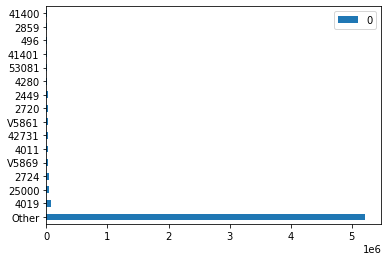

In [86]:
all_16_diag_codes_count = getTotalCodeCounts(treat_codes_one_hot, diagnosis_code_columns)
pd.DataFrame.from_dict(all_16_diag_codes_count, orient='index').plot(kind='barh')

In [49]:
def getCountsFromDict(keys, dictionary):
    new_count_dict = {}
    for key in keys:
        new_count_dict[key] = dictionary[key]
    return new_count_dict



In [50]:
fraud_unique_code_counts = getCountsFromDict(fraud_diag_unique_code, fraud_all_diag_codes_counts)
fraud_unique_code_counts

{'80491': 1,
 '80071': 1,
 '65983': 1,
 '94255': 1,
 '86354': 2,
 '7457': 3,
 '7584': 1,
 'E9108': 1,
 '0303': 1,
 '64303': 2,
 '74312': 2,
 '37060': 1,
 '1276': 1,
 '80393': 1,
 '65421': 4,
 '20192': 1,
 '04511': 1,
 '65173': 1,
 '7445': 1,
 '37909': 3,
 '80173': 3,
 '9734': 1,
 '37916': 1,
 '36024': 1,
 '1023': 1,
 '85252': 1,
 '85184': 1,
 '9607': 2,
 '01791': 1,
 '0229': 1,
 '71164': 4,
 '71172': 1,
 '64272': 1,
 '0632': 1,
 '94108': 1,
 '66481': 1,
 '80454': 1,
 'E9673': 1,
 '64213': 1,
 '36354': 1,
 '80339': 1,
 'V2389': 2,
 '1322': 1,
 '9789': 1,
 '36062': 1,
 '86513': 1,
 '80446': 1,
 '80145': 1,
 '64820': 1,
 '80021': 1,
 '85119': 1,
 '1308': 1,
 '9699': 2,
 '66491': 1,
 '1300': 1,
 '86804': 2,
 '85214': 1,
 '0913': 1,
 '0843': 1,
 '86101': 1,
 'E8237': 1,
 '0498': 1,
 '37724': 1,
 '65661': 1,
 '94219': 2,
 '80096': 1,
 '9892': 2,
 '80006': 1,
 '94440': 2,
 'E9687': 3,
 '80020': 3,
 '6172': 2,
 '3779': 2,
 '80069': 1,
 '65911': 1,
 '65611': 2,
 '80414': 1,
 'E8219': 2,
 '3769'

In [51]:
non_fraud_unique_code_counts = getCountsFromDict(non_fraud_diag_unique_code, non_fraud_all_diag_codes_counts)
non_fraud_unique_code_counts

{'52140': 2,
 'E9511': 2,
 '32361': 1,
 '65171': 2,
 '1329': 2,
 '74335': 1,
 '37811': 6,
 '64662': 1,
 '0211': 1,
 '80123': 1,
 'V272': 1,
 '74101': 2,
 '69515': 6,
 '71184': 6,
 '1279': 4,
 'E8624': 1,
 'E9551': 1,
 '64721': 1,
 '94432': 1,
 '74341': 1,
 '90189': 1,
 'E9821': 1,
 '37771': 1,
 '94154': 2,
 '94418': 1,
 '71112': 1,
 '3024': 1,
 '85196': 3,
 '11512': 3,
 '64600': 1,
 '9278': 1,
 '7519': 3,
 '80352': 2,
 '30530': 2,
 '85189': 1,
 '30451': 1,
 '2340': 1,
 '75435': 1,
 '8069': 2,
 'V251': 1,
 '75251': 1,
 '05449': 3,
 'E9029': 1,
 '9528': 1,
 '36455': 2,
 '3221': 1,
 '1631': 2,
 '80345': 3,
 '30250': 1,
 '9091': 5,
 '80342': 1,
 '01201': 1,
 'E9507': 1,
 '9821': 1,
 '80376': 1,
 '85416': 1,
 '36029': 1,
 '37171': 2,
 '36411': 4,
 '94113': 1,
 '80165': 1,
 '73074': 2,
 '32372': 1,
 '025': 1,
 '37613': 1,
 '1848': 1,
 '3759': 1,
 '64620': 1,
 '67664': 1,
 '37712': 2,
 '0052': 4,
 '7483': 6,
 '01302': 1,
 'E9463': 1,
 '9013': 1,
 'E8853': 4,
 'V253': 2,
 '80222': 1,
 '9741': 

In [52]:
def sumAllCounts(dictionary):
    sum = 0
    for key in dictionary:
        sum += dictionary[key]
    return sum    

In [55]:
print('Total Fraud Code Count = ', sumAllCounts(fraud_all_diag_codes_counts))
print('Total Non_Fraud Code Count = ', sumAllCounts(non_fraud_all_diag_codes_counts))
print('Total Fraud Specific Code Count = ', sumAllCounts(fraud_unique_code_counts))
print('Total Non_Fraud Specific Code Count = ', sumAllCounts(non_fraud_unique_code_counts))

Total Fraud Code Count =  684198
Total Non_Fraud Code Count =  996518
Total Fraud Specific Code Count =  845
Total Non_Fraud Specific Code Count =  2315


In [62]:
fraud_all_diag_codes_df = pd.DataFrame.from_dict(fraud_all_diag_codes_counts, orient='index')
fraud_all_diag_codes_df.head(50)

,0
4019,31029
25000,15087
2724,14690
V5869,9116
42731,8698
4011,8652
V5861,7629
2449,7276
2720,7121
4280,7115


In [64]:
# get a copy of the merged data, prepare change all to numerical
merged_num = pd.read_csv('../project2/merged_num.csv')
merged_num

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,Chronic_KidneyDisease_Frac,Chronic_Cancer_Frac,Chronic_ObstrPulmonary_Frac,Chronic_Depression_Frac,Chronic_Diabetes_Frac,Chronic_IschemicHeart_Frac,Chronic_Osteoporasis_Frac,Chronic_rheumatoidarthritis_Frac,Chronic_stroke_Frac,Deceased_Frac
0,PRV51001,0,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,...,0.680000,0.200000,0.400000,0.360000,0.840000,0.920000,0.240000,0.320000,0.240000,0.000000
1,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0.484848,0.075758,0.310606,0.409091,0.757576,0.848485,0.250000,0.287879,0.090909,0.007576
2,PRV51004,0,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,...,0.335570,0.107383,0.275168,0.422819,0.704698,0.724832,0.328859,0.308725,0.114094,0.006711
3,PRV51005,1,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,...,0.435193,0.141631,0.253219,0.416309,0.685837,0.768240,0.295279,0.284120,0.106438,0.003433
4,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0.305556,0.166667,0.222222,0.402778,0.680556,0.708333,0.291667,0.305556,0.166667,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,...,0.535714,0.142857,0.392857,0.321429,0.714286,1.000000,0.464286,0.321429,0.142857,0.000000
5406,PRV57760,0,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,...,0.090909,0.000000,0.090909,0.318182,0.818182,1.000000,0.500000,0.045455,0.000000,0.000000
5407,PRV57761,0,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,...,0.487805,0.170732,0.365854,0.463415,0.670732,0.756098,0.390244,0.292683,0.121951,0.012195
5408,PRV57762,0,0.000000,0.0,12.000000,12.000000,2540.000000,2540,2540,400.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [71]:
code_num_agg = treat_codes_df.groupby('Provider').agg(MaxDiagCodeNumPerClaim = ('DiagnosisCodeCount', 'max'),
                                                      MeanDiagCodeNumPerClaim = ('DiagnosisCodeCount', 'mean'),
                                                      MaxProcCodeNumPerClaim = ('ProcedureCodeCount', 'max'),
                                                      MeanProcCodeNumPerClaim = ('ProcedureCodeCount', 'mean'))
code_num_agg

,MaxDiagCodeNumPerClaim,MeanDiagCodeNumPerClaim,MaxProcCodeNumPerClaim,MeanProcCodeNumPerClaim
Provider,,,,
PRV51001,9,3.200000,2,0.120000
PRV51003,10,5.250000,2,0.363636
PRV51004,9,2.583893,0,0.000000
PRV51005,10,2.588841,0,0.000000
PRV51007,10,2.986111,1,0.013889
...,...,...,...,...
PRV57759,5,2.071429,0,0.000000
PRV57760,7,2.363636,0,0.000000
PRV57761,9,2.670732,0,0.000000


In [72]:
final_merged = merged_num.merge(code_num_agg, on = 'Provider', how = 'left')
final_merged

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,Chronic_Diabetes_Frac,Chronic_IschemicHeart_Frac,Chronic_Osteoporasis_Frac,Chronic_rheumatoidarthritis_Frac,Chronic_stroke_Frac,Deceased_Frac,MaxDiagCodeNumPerClaim,MeanDiagCodeNumPerClaim,MaxProcCodeNumPerClaim,MeanProcCodeNumPerClaim
0,PRV51001,0,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,...,0.840000,0.920000,0.240000,0.320000,0.240000,0.000000,9,3.200000,2,0.120000
1,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0.757576,0.848485,0.250000,0.287879,0.090909,0.007576,10,5.250000,2,0.363636
2,PRV51004,0,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,...,0.704698,0.724832,0.328859,0.308725,0.114094,0.006711,9,2.583893,0,0.000000
3,PRV51005,1,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,...,0.685837,0.768240,0.295279,0.284120,0.106438,0.003433,10,2.588841,0,0.000000
4,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0.680556,0.708333,0.291667,0.305556,0.166667,0.013889,10,2.986111,1,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,...,0.714286,1.000000,0.464286,0.321429,0.142857,0.000000,5,2.071429,0,0.000000
5406,PRV57760,0,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,...,0.818182,1.000000,0.500000,0.045455,0.000000,0.000000,7,2.363636,0,0.000000
5407,PRV57761,0,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,...,0.670732,0.756098,0.390244,0.292683,0.121951,0.012195,9,2.670732,0,0.000000
5408,PRV57762,0,0.000000,0.0,12.000000,12.000000,2540.000000,2540,2540,400.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1,1.000000,0,0.000000


In [173]:
! pip3 install category_encoders

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 69 kB 2.7 MB/s eta 0:00:01
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [178]:
treat_codes_df['PotentialFraud'] = treat_codes_df['PotentialFraud'].apply(lambda x: 1 if x == 'Yes' else 0)

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/1299322766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df['PotentialFraud'] = treat_codes_df['PotentialFraud'].apply(lambda x: 1 if x == 'Yes' else 0)


In [193]:
treat_codes_df.columns


Index(['Provider', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'In_Out', 'PotentialFraud',
       'DiagnosisCodeCount', 'ProcedureCodeCount', 'ClmDiagHighFreqCount',
       'ClmDiagMediumHighFreqCount', 'ClmDiagMediumFreqCount',
       'ClmDiagLowFreqCount', 'ClmDiagRareFreqCount', 'ClmProcHighFreqCount',
       'ClmProcMediumHighFreqCount', 'ClmProcMediumFreqCount',
       'ClmProcLowFreqCount', 'ClmProcRareFreqCount', 'te_ClmDiagnosisCode_1',
       'te_ClmDiagnosisCode_2', 'te_ClmDiagnosisCode_3',
       'te_ClmDiagnosisCode_4', 'te_ClmDiagnosisCode_5',
       'te_ClmDiagnosisCode_6', 'te_ClmDiagnosisCode_7',
       'te_ClmDiagnosisCode_8', 'te_

In [194]:
columns_to_drop = ['te_ClmDiagnosisCode_1',
       'te_ClmDiagnosisCode_2', 'te_ClmDiagnosisCode_3',
       'te_ClmDiagnosisCode_4', 'te_ClmDiagnosisCode_5',
       'te_ClmDiagnosisCode_6', 'te_ClmDiagnosisCode_7',
       'te_ClmDiagnosisCode_8', 'te_ClmDiagnosisCode_9',
       'te_ClmDiagnosisCode_10', 'sumTeDiaCode', 'te_ClmProcedureCode_1',
       'te_ClmProcedureCode_2', 'te_ClmProcedureCode_3',
       'te_ClmProcedureCode_4', 'te_ClmProcedureCode_5']

In [195]:
treat_codes_df.drop(columns=columns_to_drop, inplace=True)
treat_codes_df

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/3219105913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df.drop(columns=columns_to_drop, inplace=True)


,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,ClmDiagHighFreqCount,ClmDiagMediumHighFreqCount,ClmDiagMediumFreqCount,ClmDiagLowFreqCount,ClmDiagRareFreqCount,ClmProcHighFreqCount,ClmProcMediumHighFreqCount,ClmProcMediumFreqCount,ClmProcLowFreqCount,ClmProcRareFreqCount
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,...,2,1,3,2,1,0,0,0,0,0
1,PRV55907,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,...,0,1,1,0,1,0,0,0,1,0
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,...,0,0,4,0,2,0,0,0,0,0
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,...,1,1,4,1,2,0,0,1,0,0
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,...,0,2,3,1,3,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV53699,NaN,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,3,0,0,0,0,0
558207,PRV53702,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
558208,PRV53676,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0
558209,PRV53689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [222]:
for column in diagnosis_code_columns:
    treat_codes_df[column] = treat_codes_df[column].apply(lambda x: '-9999' if pd.isna(x) else x)

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/3906946154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[column] = treat_codes_df[column].apply(lambda x: '-9999' if pd.isna(x) else x)


In [230]:
for column in procedure_code_columns:
    treat_codes_df[column] = treat_codes_df[column].apply(lambda x: '-9999' if pd.isna(x) else str(x))

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2577921880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[column] = treat_codes_df[column].apply(lambda x: '-9999' if pd.isna(x) else str(x))


In [231]:
treat_codes_df

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,te_ClmDiagnosisCode_8,te_ClmDiagnosisCode_9,te_ClmDiagnosisCode_10,sumTeDiaCode,te_ClmProcedureCode_1,te_ClmProcedureCode_2,te_ClmProcedureCode_3,te_ClmProcedureCode_4,te_ClmProcedureCode_5,sumTeProcCode
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,...,0.473684,0.571865,0.379795,1.260199,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
1,PRV55907,750,6186,2948,56400,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.340553,7092.0,-9999.0,-9999.0,-9999.0,-9999.0,-12906.0
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,-9999,-9999,...,0.369850,0.371186,0.379795,1.126373,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,...,0.573265,0.523719,0.379795,1.559131,331.0,-9999.0,-9999.0,-9999.0,-9999.0,-19667.0
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,...,0.642857,0.500000,0.379795,1.223760,3893.0,-9999.0,-9999.0,-9999.0,-9999.0,-16105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV53699,NaN,2163,V4575,53190,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.311656,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
558207,PRV53702,NaN,07041,5781,25000,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.149223,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
558208,PRV53676,NaN,V570,78079,-9999,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.075579,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
558209,PRV53689,NaN,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.099000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0


In [205]:
import category_encoders as ce
te = ce.TargetEncoder()

/usr/local/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [225]:
for column in diagnosis_code_columns:
    new_column = 'te_' + column 
    treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])
    

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/630553430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])
/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/630553430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])
/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipy

In [226]:
treat_codes_df['sumTeDiaCode'] = treat_codes_df['te_ClmDiagnosisCode_1'] + treat_codes_df['te_ClmDiagnosisCode_2'] +treat_codes_df['te_ClmDiagnosisCode_3'] 
+ treat_codes_df['te_ClmDiagnosisCode_4'] +treat_codes_df['te_ClmDiagnosisCode_5'] + treat_codes_df['te_ClmDiagnosisCode_6'] 
+ treat_codes_df['te_ClmDiagnosisCode_7'] +treat_codes_df['te_ClmDiagnosisCode_8'] + treat_codes_df['te_ClmDiagnosisCode_9'] + treat_codes_df['te_ClmDiagnosisCode_10']   

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2570577901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df['sumTeDiaCode'] = treat_codes_df['te_ClmDiagnosisCode_1'] + treat_codes_df['te_ClmDiagnosisCode_2'] +treat_codes_df['te_ClmDiagnosisCode_3']


0         1.895397
1         1.489761
2         1.489761
3         1.876779
4         2.022652
            ...   
558206    1.489761
558207    1.489761
558208    1.489761
558209    1.489761
558210    1.669852
Length: 558211, dtype: float64

In [227]:
treat_codes_df

,Provider,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,te_ClmDiagnosisCode_8,te_ClmDiagnosisCode_9,te_ClmDiagnosisCode_10,sumTeDiaCode,te_ClmProcedureCode_1,te_ClmProcedureCode_2,te_ClmProcedureCode_3,te_ClmProcedureCode_4,te_ClmProcedureCode_5,sumTeProcCode
0,PRV55912,201,1970,4019,5853,7843,2768,71590,2724,19889,...,0.473684,0.571865,0.379795,1.260199,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
1,PRV55907,750,6186,2948,56400,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.340553,7092.0,-9999.0,-9999.0,-9999.0,-9999.0,-12906.0
2,PRV56046,883,29623,30390,71690,34590,V1581,32723,-9999,-9999,...,0.369850,0.371186,0.379795,1.126373,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
3,PRV52405,067,43491,2762,7843,32723,V1041,4254,25062,40390,...,0.573265,0.523719,0.379795,1.559131,331.0,-9999.0,-9999.0,-9999.0,-9999.0,-19667.0
4,PRV56614,975,042,3051,34400,5856,42732,486,5119,29620,...,0.642857,0.500000,0.379795,1.223760,3893.0,-9999.0,-9999.0,-9999.0,-9999.0,-16105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV53699,NaN,2163,V4575,53190,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.311656,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
558207,PRV53702,NaN,07041,5781,25000,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.149223,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
558208,PRV53676,NaN,V570,78079,-9999,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.075579,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0
558209,PRV53689,NaN,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,0.369850,0.371186,0.379795,1.099000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-29997.0


In [232]:
for column in procedure_code_columns:
    print(column)
    new_column = 'te_' + column 
    treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])

ClmProcedureCode_1


/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2865233251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])


ClmProcedureCode_2


/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2865233251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])


ClmProcedureCode_3


/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2865233251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])


ClmProcedureCode_4


/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2865233251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])


ClmProcedureCode_5


/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/2865233251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df[new_column] = te.fit_transform(treat_codes_df[column], treat_codes_df['PotentialFraud'])


In [233]:
treat_codes_df['sumTeProcCode'] = treat_codes_df['te_ClmProcedureCode_1'] + treat_codes_df['te_ClmProcedureCode_2'] +treat_codes_df['te_ClmProcedureCode_3'] 
+ treat_codes_df['te_ClmProcedureCode_4'] +treat_codes_df['te_ClmProcedureCode_5'] 

/var/folders/4r/5r7tbtx178l60wyz85w2n3l4l0q0z9/T/ipykernel_9648/3460002968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_codes_df['sumTeProcCode'] = treat_codes_df['te_ClmProcedureCode_1'] + treat_codes_df['te_ClmProcedureCode_2'] +treat_codes_df['te_ClmProcedureCode_3']


0         0.762361
1         0.762361
2         0.762361
3         0.762361
4         0.762361
            ...   
558206    0.762361
558207    0.762361
558208    0.762361
558209    0.762361
558210    0.762361
Length: 558211, dtype: float64

In [235]:
treat_codes_df.columns

Index(['Provider', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'In_Out', 'PotentialFraud',
       'DiagnosisCodeCount', 'ProcedureCodeCount', 'ClmDiagHighFreqCount',
       'ClmDiagMediumHighFreqCount', 'ClmDiagMediumFreqCount',
       'ClmDiagLowFreqCount', 'ClmDiagRareFreqCount', 'ClmProcHighFreqCount',
       'ClmProcMediumHighFreqCount', 'ClmProcMediumFreqCount',
       'ClmProcLowFreqCount', 'ClmProcRareFreqCount', 'te_ClmDiagnosisCode_1',
       'te_ClmDiagnosisCode_2', 'te_ClmDiagnosisCode_3',
       'te_ClmDiagnosisCode_4', 'te_ClmDiagnosisCode_5',
       'te_ClmDiagnosisCode_6', 'te_ClmDiagnosisCode_7',
       'te_ClmDiagnosisCode_8', 'te_

In [237]:
te_encoding_agg = treat_codes_df.groupby('Provider').agg(MeanTeDiagCode_1 = ('te_ClmDiagnosisCode_1', 'mean'),
                                                      MeanTeDiagCode_2 = ('te_ClmDiagnosisCode_2', 'mean'),
                                                      MeanTeDiagCode_3 = ('te_ClmDiagnosisCode_3', 'mean'),
                                                      MeanTeDiagCode_4 = ('te_ClmDiagnosisCode_4', 'mean'),
                                                      MeanTeDiagCode_5 = ('te_ClmDiagnosisCode_5', 'mean'),
                                                      MeanTeDiagCode_6 = ('te_ClmDiagnosisCode_6', 'mean'),
                                                      MeanTeDiagCode_7 = ('te_ClmDiagnosisCode_7', 'mean'),
                                                      MeanTeDiagCode_8 = ('te_ClmDiagnosisCode_8', 'mean'),
                                                      MeanTeDiagCode_9 = ('te_ClmDiagnosisCode_9', 'mean'),
                                                      MeanTeDiagCode_10 = ('te_ClmDiagnosisCode_10', 'mean'),
                                                      TotalTeDiagCode = ('sumTeDiaCode', 'mean'),
                                                      MeanTeProcCode_1 = ('te_ClmProcedureCode_1', 'mean'),
                                                      MeanTeProcCode_2 = ('te_ClmProcedureCode_2', 'mean'),
                                                      MeanTeProcCode_3 = ('te_ClmProcedureCode_3', 'mean'),
                                                      MeanTeProcCode_4 = ('te_ClmProcedureCode_4', 'mean'),
                                                      MeanTeProcCode_5 = ('te_ClmProcedureCode_5', 'mean'),
                                                      TotalProcCode = ('sumTeProcCode', 'mean')  )



In [238]:
te_encoding_agg

,MeanTeDiagCode_1,MeanTeDiagCode_2,MeanTeDiagCode_3,MeanTeDiagCode_4,MeanTeDiagCode_5,MeanTeDiagCode_6,MeanTeDiagCode_7,MeanTeDiagCode_8,MeanTeDiagCode_9,MeanTeDiagCode_10,TotalTeDiagCode,MeanTeProcCode_1,MeanTeProcCode_2,MeanTeProcCode_3,MeanTeProcCode_4,MeanTeProcCode_5,TotalProcCode
Provider,,,,,,,,,,,,,,,,,
PRV51001,0.390679,0.369875,0.374415,0.382919,0.387678,0.400158,0.372146,0.374859,0.376073,0.379795,1.134969,0.391018,0.388491,0.380863,0.381155,0.381206,1.160372
PRV51003,0.432145,0.404516,0.408474,0.411186,0.421545,0.419222,0.427367,0.419052,0.423177,0.384119,1.245135,0.431365,0.391426,0.380863,0.381155,0.381206,1.203654
PRV51004,0.365755,0.374891,0.377863,0.374315,0.372666,0.374784,0.374127,0.376476,0.373956,0.379795,1.118509,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
PRV51005,0.381302,0.379296,0.381563,0.379836,0.376932,0.375803,0.374249,0.373782,0.373076,0.379898,1.142160,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
PRV51007,0.371179,0.381601,0.376462,0.373254,0.381210,0.376165,0.376757,0.378580,0.378804,0.380071,1.129242,0.373426,0.379124,0.380863,0.381155,0.381206,1.133414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57759,0.374334,0.370671,0.361524,0.373304,0.369336,0.368170,0.368930,0.369850,0.371186,0.379795,1.106529,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
PRV57760,0.371237,0.374428,0.374689,0.377466,0.378179,0.359836,0.373435,0.369850,0.371186,0.379795,1.120354,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
PRV57761,0.364505,0.378246,0.376151,0.377486,0.368192,0.367063,0.372585,0.369617,0.370118,0.379795,1.118903,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528


In [239]:
final_merged = final_merged.merge(te_encoding_agg, on='Provider', how = 'left')

In [240]:
final_merged

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,MeanTeDiagCode_8,MeanTeDiagCode_9,MeanTeDiagCode_10,TotalTeDiagCode,MeanTeProcCode_1,MeanTeProcCode_2,MeanTeProcCode_3,MeanTeProcCode_4,MeanTeProcCode_5,TotalProcCode
0,PRV51001,0,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,...,0.374859,0.376073,0.379795,1.134969,0.391018,0.388491,0.380863,0.381155,0.381206,1.160372
1,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0.419052,0.423177,0.384119,1.245135,0.431365,0.391426,0.380863,0.381155,0.381206,1.203654
2,PRV51004,0,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,...,0.376476,0.373956,0.379795,1.118509,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
3,PRV51005,1,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,...,0.373782,0.373076,0.379898,1.142160,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
4,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0.378580,0.378804,0.380071,1.129242,0.373426,0.379124,0.380863,0.381155,0.381206,1.133414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,...,0.369850,0.371186,0.379795,1.106529,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5406,PRV57760,0,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,...,0.369850,0.371186,0.379795,1.120354,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5407,PRV57761,0,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,...,0.369617,0.370118,0.379795,1.118903,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5408,PRV57762,0,0.000000,0.0,12.000000,12.000000,2540.000000,2540,2540,400.000000,...,0.369850,0.371186,0.379795,1.087311,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528


In [242]:
for column in final_merged.columns:
    print(column)

Provider
PotentialFraud
DeductibleAmtPaid_mean
DeductibleAmtPaid_max
NoOfMonths_PartACov_mean
NoOfMonths_PartBCov_mean
OPAnnualReimbursementAmt_mean
OPAnnualReimbursementAmt_max
OPAnnualReimbursementAmt_sum
OPAnnualDeductibleAmt_mean
OPAnnualDeductibleAmt_max
OPAnnualDeductibleAmt_sum
ClaimCounts
Gender
ClaimPeriod
RaceOneFrac
MajorRace
RenalDiseaseIndicator
Age
uniqBeneCount
ClmsperBene
TotalInscClaimAmtReimbursed
MeanInscClaimAmtReimbursed
MaxInscClaimAmtReimbursed
uniqATPhysnCount
ClmsperATPhysn
uniqOPPhysnCount
ClmsperOPPhysn
uniqOTPhysnCount
ClmsperOTPhysn
InClmsPct
StateCount_Uniq
MajorState
CountyCount_Uniq
MajorCounty
TotalIPAnnualReimbursementAmt
MeanIPAnnualReimbursementAmt
MaxIPAnnualReimbursementAmt
TotalIPAnnualDeductibleAmtdf
MeanIPAnnualDeductibleAmt
MaxIPAnnualDeductibleAmt
MaxHospitalDays
MedianHospitalDays
MeanHospitalDays
Chronic_Alzheimer_Frac
Chronic_Heartfailure_Frac
Chronic_KidneyDisease_Frac
Chronic_Cancer_Frac
Chronic_ObstrPulmonary_Frac
Chronic_Depression_Frac

In [243]:
'''Export to csv'''
from pathlib import Path
filepath = Path('../project2/merged_num_cat_2.csv')
final_merged.to_csv(filepath, index=False)

In [251]:
train_provider = pd.read_csv('../project2/train_provider_list.csv')
test_provide = pd.read_csv('../project2/test_provider_list.csv')

In [252]:
train_provider_list = train_provider.Provider.to_list()
test_provider_list = test_provider.Provider.to_list()

In [278]:
train_all = final_merged[final_merged['Provider'].isin(train_provider_list)]

In [257]:
train_all = final_merged[final_merged['Provider'].isin(train_provider_list)]

In [258]:
train_all

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,MeanTeDiagCode_8,MeanTeDiagCode_9,MeanTeDiagCode_10,TotalTeDiagCode,MeanTeProcCode_1,MeanTeProcCode_2,MeanTeProcCode_3,MeanTeProcCode_4,MeanTeProcCode_5,TotalProcCode
0,PRV51001,0,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,...,0.374859,0.376073,0.379795,1.134969,0.391018,0.388491,0.380863,0.381155,0.381206,1.160372
2,PRV51004,0,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,...,0.376476,0.373956,0.379795,1.118509,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
3,PRV51005,1,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,...,0.373782,0.373076,0.379898,1.142160,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5,PRV51008,0,53.860465,1068.0,12.000000,12.000000,2570.465116,20500,110530,616.046512,...,0.373877,0.372938,0.379828,1.117358,0.378247,0.379124,0.380863,0.381155,0.381206,1.138235
6,PRV51011,0,23.586207,1068.0,12.000000,12.000000,1399.310345,6340,81160,366.724138,...,0.382467,0.377132,0.379795,1.112323,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5404,PRV57758,0,0.000000,0.0,12.000000,12.000000,2570.000000,4340,5140,500.000000,...,0.369850,0.371186,0.379795,1.141532,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5405,PRV57759,0,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,...,0.369850,0.371186,0.379795,1.106529,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5406,PRV57760,0,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,...,0.369850,0.371186,0.379795,1.120354,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5407,PRV57761,0,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,...,0.369617,0.370118,0.379795,1.118903,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528


In [259]:
y_train_new = train_all['PotentialFraud']

In [260]:
y_train_new

0       0
2       0
3       1
5       0
6       0
       ..
5404    0
5405    0
5406    0
5407    0
5409    0
Name: PotentialFraud, Length: 4328, dtype: int64

In [261]:
'''Export to csv'''
from pathlib import Path
filepath = Path('../project2/y_train_new.csv')
y_train_new.to_csv(filepath, index=False)

In [262]:
X_train_new = train_all.drop(columns=['PotentialFraud'])

In [263]:
X_train_new

,Provider,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,OPAnnualDeductibleAmt_max,...,MeanTeDiagCode_8,MeanTeDiagCode_9,MeanTeDiagCode_10,TotalTeDiagCode,MeanTeProcCode_1,MeanTeProcCode_2,MeanTeProcCode_3,MeanTeProcCode_4,MeanTeProcCode_5,TotalProcCode
0,PRV51001,213.600000,1068.0,12.000000,12.000000,2615.200000,13460,65380,463.920000,2700,...,0.374859,0.376073,0.379795,1.134969,0.391018,0.388491,0.380863,0.381155,0.381206,1.160372
2,PRV51004,2.080537,100.0,11.865772,11.959732,2194.899329,20900,327040,622.751678,7410,...,0.376476,0.373956,0.379795,1.118509,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
3,PRV51005,3.175966,200.0,11.907296,11.939914,2109.733906,97510,2457840,636.328755,6330,...,0.373782,0.373076,0.379898,1.142160,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5,PRV51008,53.860465,1068.0,12.000000,12.000000,2570.465116,20500,110530,616.046512,4140,...,0.373877,0.372938,0.379828,1.117358,0.378247,0.379124,0.380863,0.381155,0.381206,1.138235
6,PRV51011,23.586207,1068.0,12.000000,12.000000,1399.310345,6340,81160,366.724138,1070,...,0.382467,0.377132,0.379795,1.112323,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5404,PRV57758,0.000000,0.0,12.000000,12.000000,2570.000000,4340,5140,500.000000,570,...,0.369850,0.371186,0.379795,1.141532,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5405,PRV57759,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,2810,...,0.369850,0.371186,0.379795,1.106529,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5406,PRV57760,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,2930,...,0.369850,0.371186,0.379795,1.120354,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5407,PRV57761,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,4940,...,0.369617,0.370118,0.379795,1.118903,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528


In [296]:
filepath = Path('../project2/X_train_new.csv')
X_train_new.to_csv(filepath, index=False)

In [297]:
test_provider = pd.read_csv('../project2/test_provider_list.csv')

In [284]:
test_provider_list = test_provider.Provider.to_list()

In [286]:
test_all = final_merged[final_merged['Provider'].isin(test_provider_list)]

In [287]:
test_all

,Provider,PotentialFraud,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,MeanTeDiagCode_8,MeanTeDiagCode_9,MeanTeDiagCode_10,TotalTeDiagCode,MeanTeProcCode_1,MeanTeProcCode_2,MeanTeProcCode_3,MeanTeProcCode_4,MeanTeProcCode_5,TotalProcCode
1,PRV51003,1,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0.419052,0.423177,0.384119,1.245135,0.431365,0.391426,0.380863,0.381155,0.381206,1.203654
4,PRV51007,0,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0.378580,0.378804,0.380071,1.129242,0.373426,0.379124,0.380863,0.381155,0.381206,1.133414
16,PRV51025,0,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,...,0.379912,0.382826,0.379795,1.151840,0.396727,0.384172,0.380863,0.381155,0.381206,1.161763
17,PRV51026,0,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,...,0.367247,0.372403,0.379795,1.139064,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
28,PRV51041,0,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,...,0.367284,0.371186,0.379795,1.093911,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5387,PRV57738,0,0.000000,0.0,12.000000,12.000000,2650.000000,2650,2650,220.000000,...,0.369850,0.371186,0.379795,1.220373,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5390,PRV57741,0,4.666667,70.0,12.000000,12.000000,3434.000000,13040,51510,892.666667,...,0.373562,0.376069,0.379795,1.133005,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5397,PRV57751,0,25.000000,100.0,12.000000,12.000000,5385.000000,14340,21540,362.500000,...,0.369850,0.371186,0.379795,1.117968,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5402,PRV57756,0,5.925926,90.0,12.000000,12.000000,2815.555556,34230,76020,763.333333,...,0.367548,0.376835,0.379795,1.112379,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528


In [288]:
y_test= test_all.PotentialFraud

In [289]:
y_test

1       1
4       0
16      0
17      0
28      0
       ..
5387    0
5390    0
5397    0
5402    0
5408    0
Name: PotentialFraud, Length: 1082, dtype: int64

In [290]:
X_test = test_all.drop(columns=['PotentialFraud'])

In [291]:
X_test

,Provider,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,OPAnnualDeductibleAmt_max,...,MeanTeDiagCode_8,MeanTeDiagCode_9,MeanTeDiagCode_10,TotalTeDiagCode,MeanTeProcCode_1,MeanTeProcCode_2,MeanTeProcCode_3,MeanTeProcCode_4,MeanTeProcCode_5,TotalProcCode
1,PRV51003,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,9950,...,0.419052,0.423177,0.384119,1.245135,0.431365,0.391426,0.380863,0.381155,0.381206,1.203654
4,PRV51007,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,1970,...,0.378580,0.378804,0.380071,1.129242,0.373426,0.379124,0.380863,0.381155,0.381206,1.133414
16,PRV51025,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,8280,...,0.379912,0.382826,0.379795,1.151840,0.396727,0.384172,0.380863,0.381155,0.381206,1.161763
17,PRV51026,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,2700,...,0.367247,0.372403,0.379795,1.139064,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
28,PRV51041,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,7680,...,0.367284,0.371186,0.379795,1.093911,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5387,PRV57738,0.000000,0.0,12.000000,12.000000,2650.000000,2650,2650,220.000000,220,...,0.369850,0.371186,0.379795,1.220373,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5390,PRV57741,4.666667,70.0,12.000000,12.000000,3434.000000,13040,51510,892.666667,2230,...,0.373562,0.376069,0.379795,1.133005,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5397,PRV57751,25.000000,100.0,12.000000,12.000000,5385.000000,14340,21540,362.500000,780,...,0.369850,0.371186,0.379795,1.117968,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
5402,PRV57756,5.925926,90.0,12.000000,12.000000,2815.555556,34230,76020,763.333333,8780,...,0.367548,0.376835,0.379795,1.112379,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528


In [294]:
filepath_x_test = Path('../project2/X_test_new.csv')
X_test.to_csv(filepath_x_test, index=False)



In [295]:
filepath_y_test = Path('../project2/y_test_new.csv')
y_test.to_csv(filepath_y_test, index=False)

**Xgboost**

In [ ]:
from xgboost import XGBClassifier
